# NN5

## Testowanie różnych funkcji aktywacji

Należy rozszerzyć istniejącą implementację sieci i metody uczącej o możliwość wyboru funkcji aktywacji:
- sigmoid,
- liniowa,
- tanh,
- ReLU.

Pytanie dodatkowe – czy wszyscy implementują dokładnie gradient dla funkcji ReLU?

Porównać szybkość uczenia i skuteczność sieci w zależności od liczby neuronów w poszczególnych warstwach i rodzaju funkcji aktywacji. Należy wziąć pod uwagę fakt, że różne funkcje aktywacji mogą dawać różną skuteczność w zależności od liczby neuronów i liczby warstw. Sprawdzić sieci z jedną, dwiema i trzema warstwami ukrytymi. Podobnie jak w poprzednim tygodniu, trzeba dostosować proces uczenia do pochodnych nowych funkcji aktywacji.

Przeprowadzić testy wstępne dla zbioru multimodal-large (regresja), dla wszystkich trzech architektur i wszystkich czterech funkcji aktywacji.

Dla pozostałych zbiorów wybrać dwa najlepsze zestawy i zbadać ich skuteczność:
- regresja
    - steps-large,
- klasyfikacja
    - rings5-regular
    - rings3-regular

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def linear(x):
    return x

def sigmoid_der(x):
    return x * (1 - x)

def linear_der(x):
    return np.ones((len(x), 1))

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)


def softmax_der(x):
    return np.ones((len(x), 1))


def tanh(x):
    exp_x = np.exp(x)
    exp_m_x = np.exp(-x)
    return (exp_x - exp_m_x) / (exp_x + exp_m_x)

def tanh_der(x):
    return 1 - x**2

def relu(x):
    return np.maximum(0, x)

def relu_der(x):
    return (x > 0).astype(float)
    

def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.shape[0], num_classes))
    
    one_hot[np.arange(y.shape[0]), y.flatten()] = 1
    
    return one_hot

class MLP:
    def __init__(self, layer_sizes,
                 hidden_activation='sigmoid',
                 output_activation='linear', metric = 'mse'):
        self.activation_functions = {
            'sigmoid': sigmoid,
            'linear': linear,
            'softmax': softmax,
            'tanh': tanh,
            'relu': relu
        }

        self.activation_functions_der = {
            'sigmoid': sigmoid_der,
            'linear': linear_der,
            'softmax': softmax_der,
            'tanh': tanh_der,
            'relu': relu_der
        }

        self.metrics = {
            'mse': self.mse,
            'cross-entropy': self.cross_entropy,
        }

        # output_activation = "sigmoid" - tylko dla danych [0,1]
        self.metric = self.metrics[metric]
        if metric == "mse":
            self.measure = 0
        else:
            self.measure = 1
        self.hidden_activation = self.activation_functions[hidden_activation]
        self.output_activation = self.activation_functions[output_activation]
        self.loss = []
        self.output_activation_der = self.activation_functions_der[output_activation]
        self.hidden_activation_der = self.activation_functions_der[hidden_activation]
        self.weights_history = []
        self.biases_history = []
        self.layer_sizes = layer_sizes
        self.errors = []
        self.gradients = []
        np.random.seed(42)
        self.momentum = 0
        self.weights = []
        self.biases = []
        self.epsilon = 1e-8
        self.moment_weights = []
        self.moment_biases = [] 

        # Inicjalizacja wag z normalizacją (Xavier)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) / np.sqrt(layer_sizes[i])
            b = np.zeros((layer_sizes[i + 1],))
            self.weights.append(w)
            self.biases.append(b)

            self.moment_weights.append(np.zeros_like(w))
            self.moment_biases.append(np.zeros_like(b))


    def forward(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)

        activation = X
        activations = [X]
        for i in range(len(self.weights) - 1):
            weights = self.weights[i]
            biases = self.biases[i]
            Y = activation @ self.weights[i] + self.biases[i]
            activation = self.hidden_activation(Y)
            activations.append(activation)

        Y = activation @ self.weights[-1] + self.biases[-1]
        activation = self.output_activation(Y)
        activations.append(activation)
        return activations

    def predict(self, X, norm):
        if norm == 0:
            return self.forward(X)[-1]
        else:
            X = (X - self.minX) / (self.maxX - self.minX)
            y_norm  = self.forward(X)[-1]
            return y_norm * (self.max - self.min) + self.min

    def set_weights_and_biases(self, layer_idx, W, b):
        self.weights[layer_idx] = W
        self.biases[layer_idx] = b

    def cross_entropy(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        cross_entropy_loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        
        return cross_entropy_loss


    def mse(self, y_true, y_pred):
        diff = y_true - y_pred
        diff = np.clip(diff, -1e150, 1e150)  
        return np.mean((diff) ** 2)
    

    def f1_score(self, y_true, y_pred):
        
        TP = np.sum(y_true * y_pred, axis=0)
        FP = np.sum((1 - y_true) * y_pred, axis=0)
        FN = np.sum(y_true * (1 - y_pred), axis=0)
        
        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        
        return np.mean(f1)
        
    def convert_to_class_indices(self, y_pred):
        return np.argmax(y_pred, axis=1)    
    
    def softmax_to_one_hot(self, y_pred):

        y_pred_one_hot = np.zeros_like(y_pred) 
        
        class_predictions = np.argmax(y_pred, axis=1) 
        
        y_pred_one_hot[np.arange(y_pred.shape[0]), class_predictions] = 1
        
        return y_pred_one_hot

    def backpropagate(self, X, y_true, activations):
        output = activations[-1] 
        error = output - y_true 
        # self.errors.append(np.mean(np.square(error)))

        delta = error * self.output_activation_der(output)
        deltas = [delta]

        for i in range(len(self.weights) - 2, -1, -1):
            delta = deltas[-1] @ self.weights[i + 1].T * self.hidden_activation_der(activations[i + 1])
            deltas.append(delta)

        deltas.reverse()
        return deltas


    def update_weights_and_biases(self, activations, deltas, learning_rate):
        for i in range(len(self.weights)):
            activation = activations[i]
            delta = deltas[i]
            self.weights[i] -= learning_rate * activation.T @ delta
            self.biases[i] -= learning_rate * np.sum(delta, axis=0)


    def update_weights_and_biases_momentum(self, activations, deltas, learning_rate):
        for i in range(len(self.weights)):
            activation = activations[i]
            delta = deltas[i]

            gradient_w = activation.T @ delta
            gradient_b = np.sum(delta, axis=0)

            self.moment_weights[i] = self.momentum * self.moment_weights[i] - learning_rate * gradient_w
            self.moment_biases[i] = self.momentum * self.moment_biases[i] - learning_rate * gradient_b
            self.weights[i] += self.moment_weights[i]
            self.biases[i] += self.moment_biases[i]


    def update_weights_and_biases_RMS(self, activations, deltas, learning_rate):
        for i in range(len(self.weights)):
            activation = activations[i]
            delta = deltas[i]

            gradient_w = activation.T @ delta
            gradient_b = np.sum(delta, axis=0)

            self.moment_weights[i] = (1 - self.momentum) * (gradient_w ** 2) + self.momentum * self.moment_weights[i]
            self.moment_biases[i] = (1 - self.momentum) * (gradient_b ** 2) + self.momentum * self.moment_biases[i]

            self.weights[i] -= learning_rate * gradient_w / (np.sqrt(self.moment_weights[i]) + self.epsilon)
            self.biases[i] -= learning_rate * gradient_b / (np.sqrt(self.moment_biases[i]) + self.epsilon)


    def fit(self, X, y, epochs=1000, learning_rate=0.01, er=3, momentum=0, RMS =0, X_test=None, y_test=None, norm = 0):
        self.momentum = momentum
        m = X.shape[0]
        if norm == 1:
            self.min = min(y)
            self.max = max(y)
            self.minX = min(X)
            self.maxX = max(X)
            X = (X - self.minX) / (self.maxX - self.minX)
            y_norm = (y - self.min) / (self.max - self.min)
        else:
            y_norm = y
        for epoch in range(epochs):
            activations = self.forward(X)
            y_pred = self.predict(X, norm)
            error = self.metric(y, y_pred)
            self.errors.append(error)
            if self.measure == 0:
                loss = self.mse(y, y_pred)
                if loss < er:
                    print("finished_early on epoch: ", epoch, ", with loss = ", loss)
                    plt.plot(self.loss)
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.title('Training Loss')
                    plt.show()
                    return
            else:
                loss = self.f1_score(y, self.softmax_to_one_hot(y_pred))
                if loss > er:
                    print("finished_early on epoch: ", epoch, ", with f-measure = ", loss)
                    plt.plot(self.loss)
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.title('Training Loss')
                    plt.show()
                    return
            self.loss.append(loss)
            
            deltas = self.backpropagate(X, y_norm, activations)
            if RMS == 1:
                self.update_weights_and_biases_RMS(activations, deltas, learning_rate)
            elif RMS == 0 and self.momentum == 0:
                self.update_weights_and_biases(activations, deltas, learning_rate)
            else:
                self.update_weights_and_biases_momentum(activations, deltas, learning_rate)
            self.weights_history.append([w.copy() for w in self.weights])
            self.biases_history.append([w.copy() for w in self.biases])

            if (epoch) % 1000 == 0:
                if X_test is not None and y_test is not None:
                    if self.measure == 0:
                        test_loss = self.mse(y_test, self.predict(X_test, norm))
                    else:
                        test_loss = self.f1_score(y_test, self.predict(X_test, self.softmax_to_one_hot(norm)))
                    # test_loss = metric(y_test, self.predict(X_test, norm))
                    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss}, Test Loss: {test_loss}')
                else:
                    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss}, Error: {error}')
        plt.plot(self.loss)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()
        # plt.plot(self.errors)
        # plt.xlabel('Epochs')
        # plt.ylabel('Error')
        # plt.title('Training Errors')
        # plt.show()


    def visualize_weights(self, layer_idx):

        if not self.weights_history:
            print("Brak danych o wagach. Uruchom najpierw metodę fit().")
            return

        weights_for_layer = np.array([weights[layer_idx] for weights in self.weights_history])

        plt.figure(figsize=(12, 6))
        for i in range(weights_for_layer.shape[1]):
            for j in range(weights_for_layer.shape[2]):
                plt.plot(weights_for_layer[:, i, j], label=f'Neuron {i}-{j}')

        plt.xlabel("Epoch")
        plt.ylabel("Weight Value")
        plt.title(f"Weight Changes for Layer {layer_idx} Over Epochs")
        plt.legend(loc='upper right', fontsize=8)
        plt.tight_layout()
        plt.show()

    def visualize_biases(self, layer_idx):
        if not self.weights_history:
            print("Brak danych o biasach. Uruchom najpierw metodę fit().")
            return

        biases_for_layer = np.array([bias[layer_idx] for bias in self.biases_history])

        if biases_for_layer.ndim == 1:
            plt.plot(biases_for_layer, label=f"Bias w warstwie {layer_idx}", color='red')
        else:
            plt.figure(figsize=(12, 6))
            for i in range(biases_for_layer.shape[1]):
                plt.plot(biases_for_layer[:, i], label=f'Bias {i} w warstwie {layer_idx}')

        plt.xlabel("Epoki")
        plt.ylabel("Wartość biasu")
        plt.title(f"Wartości biasów dla warstwy {layer_idx} w trakcie treningu")
        plt.legend()
        plt.tight_layout()
        plt.show()


    def fit_batch(self, X, y, epochs=1000, learning_rate=0.01, er = 3, momentum=0, RMS = 0,X_test=None, y_test=None, norm = 0, batch_size=32):
        m = X.shape[0]
        self.momentum = momentum
        if norm == 1:
            self.min = min(y)
            self.max = max(y)
            self.minX = min(X)
            self.maxX = max(X)
            X = (X - self.minX) / (self.maxX - self.minX)
            y_norm = (y - self.min) / (self.max - self.min)
        else:
            y_norm = y
        for epoch in range(epochs):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            for start_idx in range(0, m, batch_size):
                end_idx = min(start_idx + batch_size, m)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                activations = self.forward(X_batch)
                deltas = self.backpropagate(X_batch, y_batch, activations)
                if RMS == 1:
                    self.update_weights_and_biases_RMS(activations, deltas, learning_rate)
                elif RMS == 0 and self.momentum == 0:
                    self.update_weights_and_biases(activations, deltas, learning_rate)
                else:
                    self.update_weights_and_biases_momentum(activations, deltas, learning_rate)
            y_pred = self.predict(X, norm)
            error = self.metric(y, y_pred)
            self.errors.append(error)
            if self.measure == 0:
                loss = self.mse(y, y_pred)
                if loss < er:
                    print("finished_early on epoch: ", epoch, ", with loss = ", loss)
                    plt.plot(self.loss)
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.title('Training Loss')
                    plt.show()
                    return
            else:
                loss = self.f1_score(y, self.softmax_to_one_hot(y_pred))
                if loss > er:
                    print("finished_early on epoch: ", epoch, ", with f-measure = ", loss)
                    plt.plot(self.loss)
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.title('Training Loss')
                    plt.show()
                    return
            self.loss.append(loss)
            
            self.weights_history.append([w.copy() for w in self.weights])
            self.biases_history.append([b.copy() for b in self.biases])
            if (epoch) % 1000 == 0:
                if X_test is not None and y_test is not None:
                    if self.measure == 0:
                        test_loss = self.mse(y_test, self.predict(X_test, norm))
                    else:
                        test_loss = self.f1_score(y_test, self.predict(X_test, self.softmax_to_one_hot(norm)))
                    # test_loss = metric(y_test, self.predict(X_test, norm))
                    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss}, Test Loss: {test_loss}')
                else:
                    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss}, Error: {error}')
        plt.plot(self.loss)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()
        plt.plot(self.errors)
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.title('Training Errors')
        plt.show()


## 1. Zbiór multimodal

### 1 warstwa ukryta

#### sigmoid

Epoch 1/10000, Train Loss: 5346.709840733268, Test Loss: 5322.603929260803
Epoch 1001/10000, Train Loss: 60.110959991772866, Test Loss: 60.21624679236629
Epoch 2001/10000, Train Loss: 21.09569222092189, Test Loss: 16.977112922898268
Epoch 3001/10000, Train Loss: 13.434395166472747, Test Loss: 8.905560368383075
Epoch 4001/10000, Train Loss: 10.496657318423846, Test Loss: 6.1201388715460086
Epoch 5001/10000, Train Loss: 8.851625839114476, Test Loss: 4.610906589155395
Epoch 6001/10000, Train Loss: 7.77813828527818, Test Loss: 3.632569731820186
Epoch 7001/10000, Train Loss: 7.06412615467149, Test Loss: 2.989338538264587
Epoch 8001/10000, Train Loss: 6.614905530645505, Test Loss: 2.5962889179273896
Epoch 9001/10000, Train Loss: 6.3452133286244905, Test Loss: 2.3680156839123034


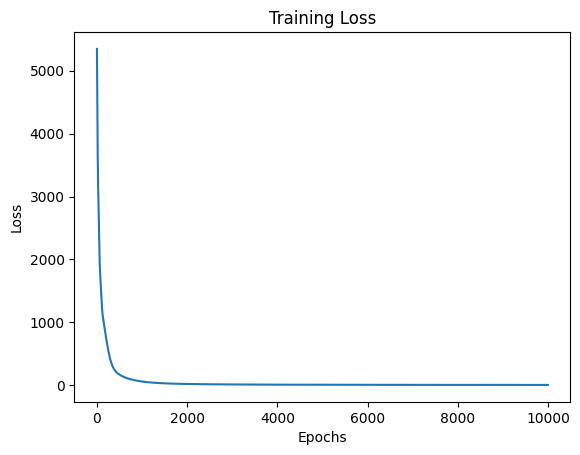

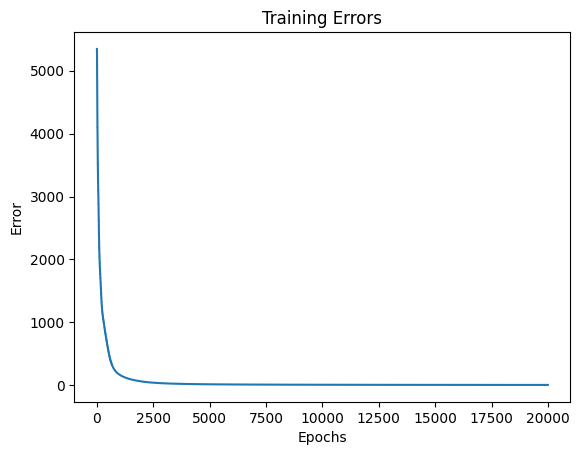

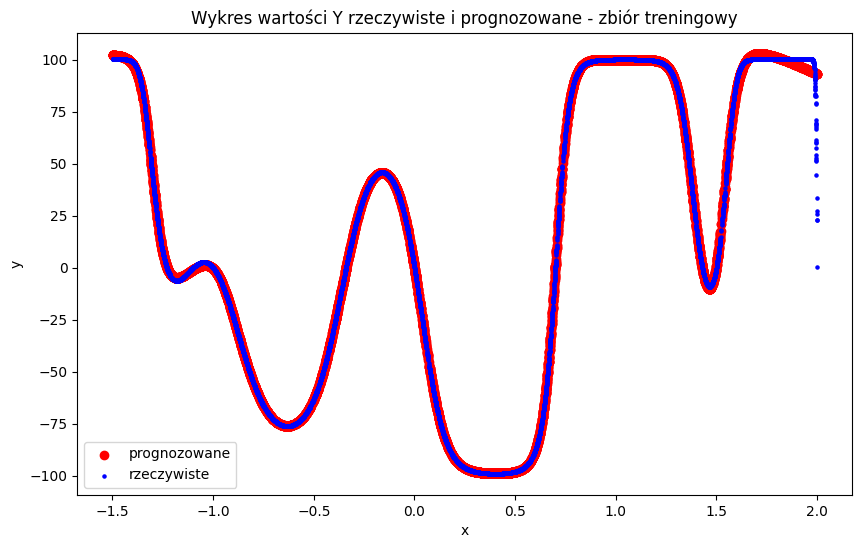

Train MSE =  6.1833556254826805
 Test MSE =  2.232297928523411


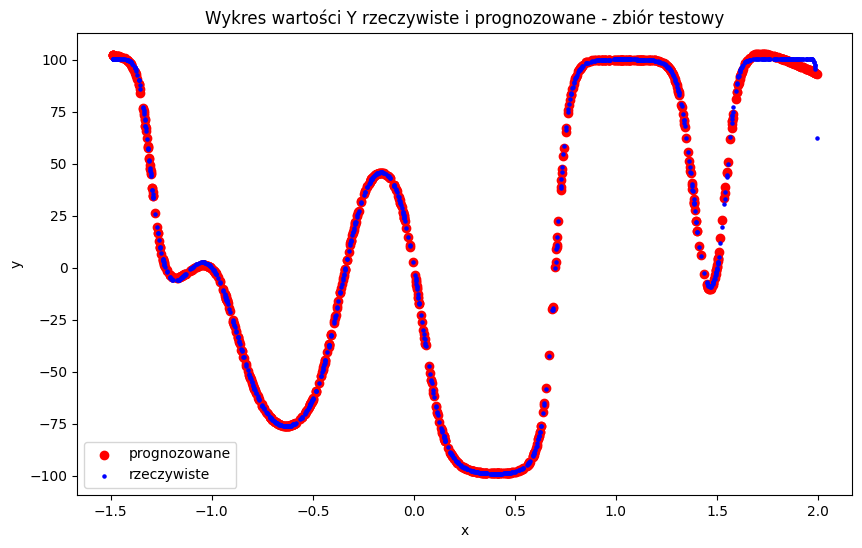

In [ ]:
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 64, 1] ,'sigmoid')

mlp.fit(X, y_true,10000, 0.000001, 0, 0.9, 0, X_test, y_true_test, 0)

y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### linear

Epoch 1/10000, Train Loss: 5348.387072868808, Test Loss: 4642.008493318204
Epoch 1001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 2001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871354
Epoch 3001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871354
Epoch 4001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871354
Epoch 5001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871354
Epoch 6001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871354
Epoch 7001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 8001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871354
Epoch 9001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355


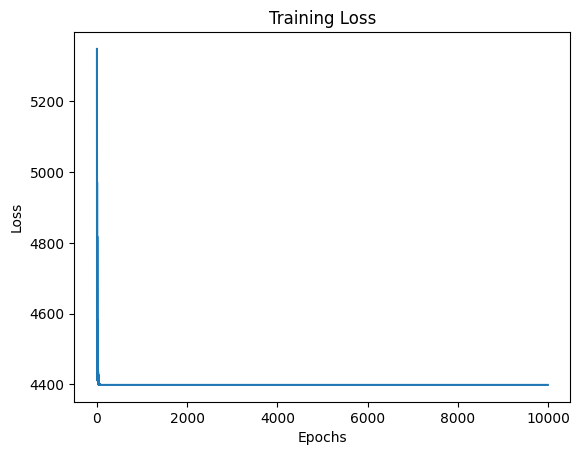

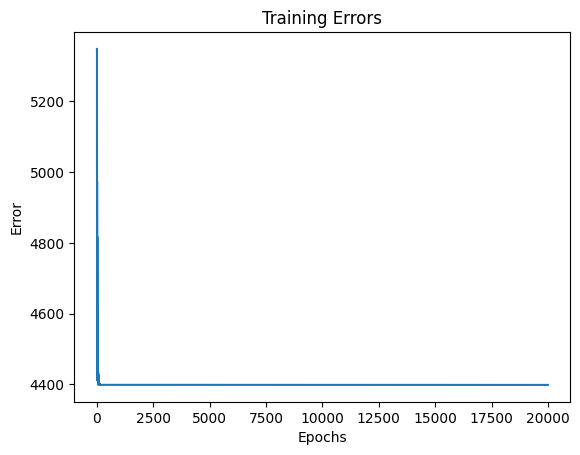

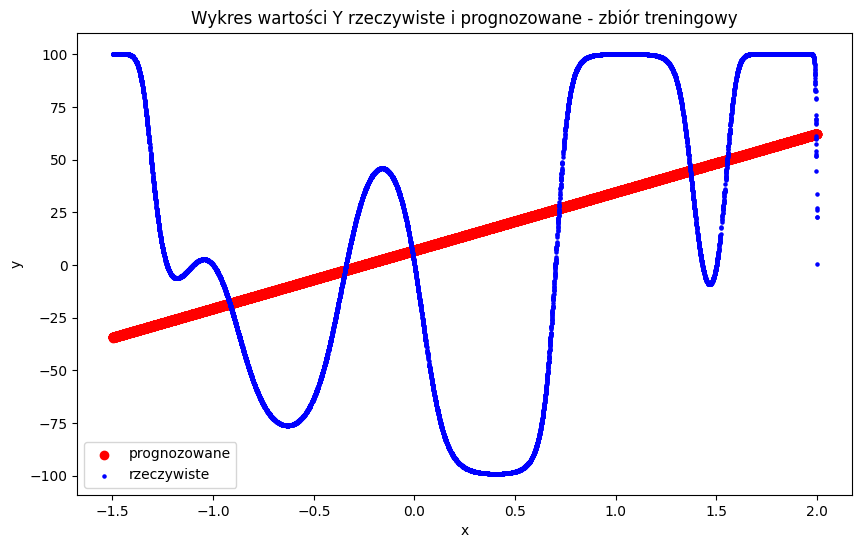

Train MSE =  4398.222171444738
 Test MSE =  4433.705680871355


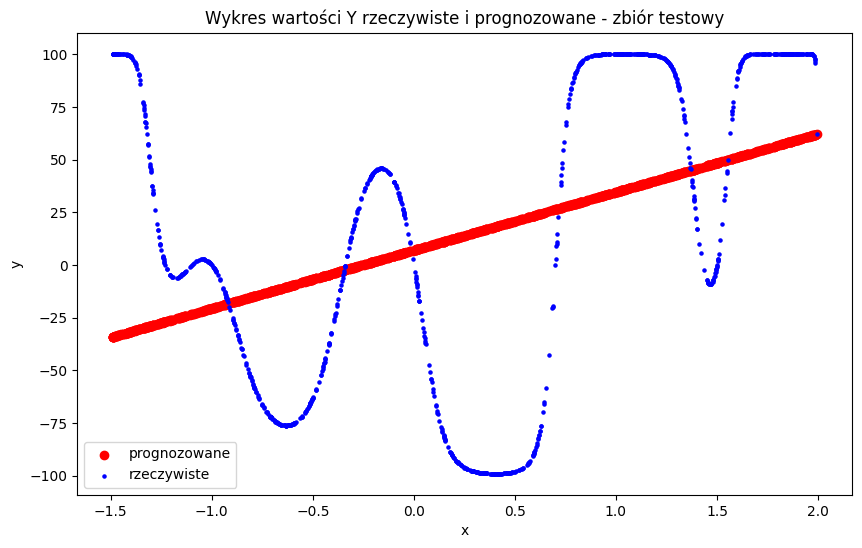

In [ ]:
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 64, 1] ,'linear')

mlp.fit(X, y_true,10000, 0.000001, 0, 0.9, 0, X_test, y_true_test, 0)

y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### tanh

Epoch 1/10000, Train Loss: 5336.570930987512, Test Loss: 5117.177461870268
Epoch 1001/10000, Train Loss: 8.739510725242964, Test Loss: 3.8391916634780316
Epoch 2001/10000, Train Loss: 7.281521597928542, Test Loss: 2.917550541623873
Epoch 3001/10000, Train Loss: 6.493695468790687, Test Loss: 2.4018733955686304
Epoch 4001/10000, Train Loss: 5.990702830057883, Test Loss: 2.087557123386698
Epoch 5001/10000, Train Loss: 5.726117386907136, Test Loss: 1.9544741440732971
Epoch 6001/10000, Train Loss: 5.554959092321892, Test Loss: 1.8967714362594452
Epoch 7001/10000, Train Loss: 5.415578162960359, Test Loss: 1.8697959433197793
Epoch 8001/10000, Train Loss: 5.285601665677014, Test Loss: 1.855943793351012
Epoch 9001/10000, Train Loss: 5.15669676999358, Test Loss: 1.8482068735851818


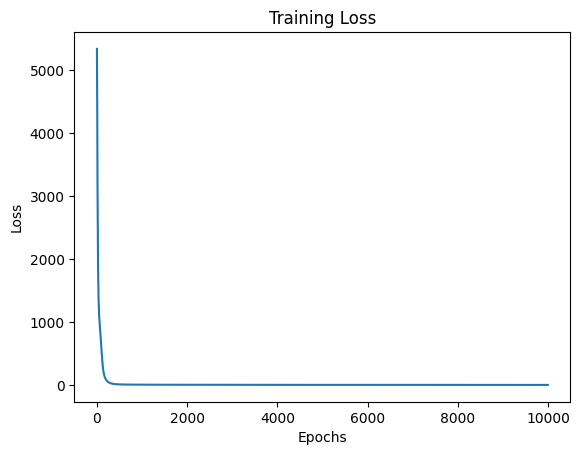

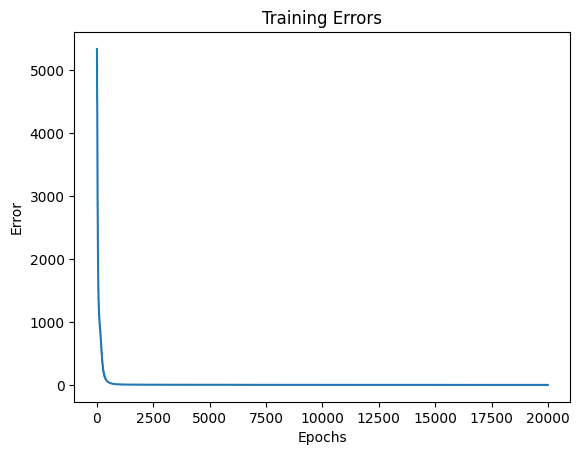

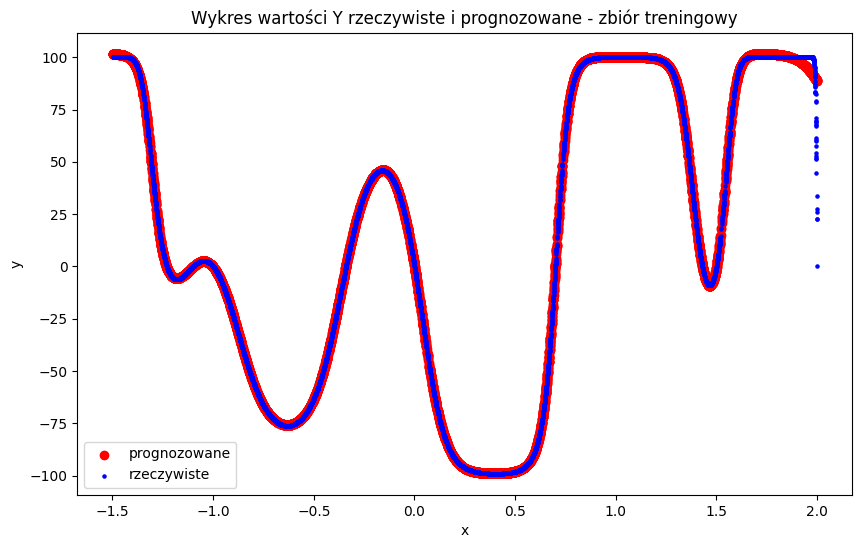

Train MSE =  5.026380789788303
 Test MSE =  1.8439118778991255


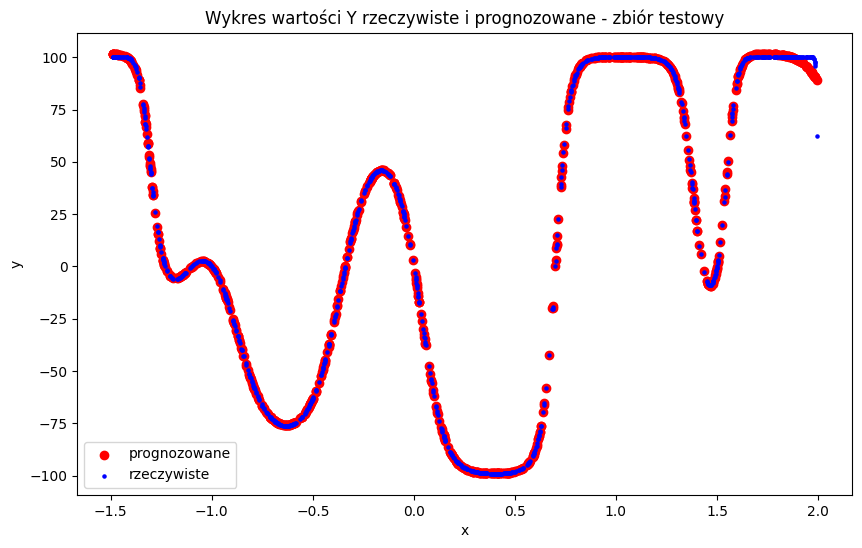

In [ ]:
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 64, 1] ,'tanh')

mlp.fit(X, y_true,10000, 0.000001, 0, 0.9, 0, X_test, y_true_test, 0)

y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### relu

Epoch 1/10000, Train Loss: 5350.217907050338, Test Loss: 4989.281809612851
Epoch 1001/10000, Train Loss: 4792.69374889, Test Loss: 4807.566091608132
Epoch 2001/10000, Train Loss: 4792.691980064343, Test Loss: 4807.562436130979
Epoch 3001/10000, Train Loss: 4792.69197982561, Test Loss: 4807.562405664616
Epoch 4001/10000, Train Loss: 4792.691979825598, Test Loss: 4807.56240545361
Epoch 5001/10000, Train Loss: 4792.691979825598, Test Loss: 4807.562405452139
Epoch 6001/10000, Train Loss: 4792.6919798255985, Test Loss: 4807.562405452129
Epoch 7001/10000, Train Loss: 4792.6919798255985, Test Loss: 4807.562405452129
Epoch 8001/10000, Train Loss: 4792.6919798255985, Test Loss: 4807.562405452129
Epoch 9001/10000, Train Loss: 4792.6919798255985, Test Loss: 4807.562405452129


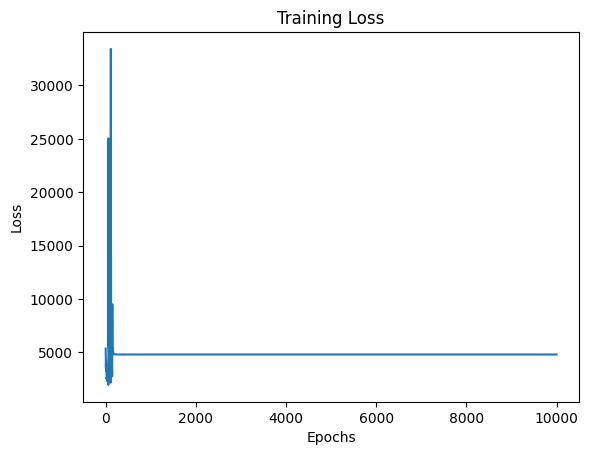

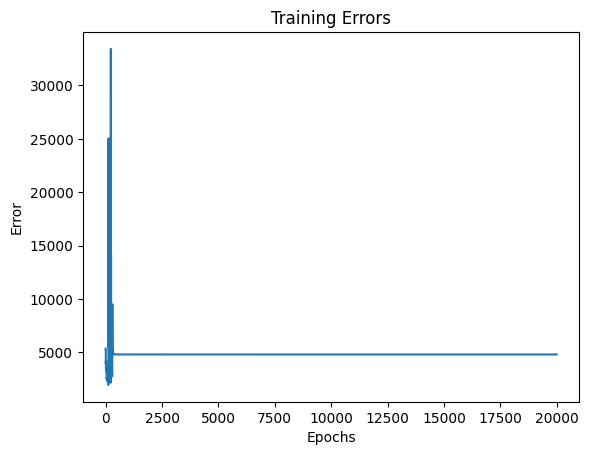

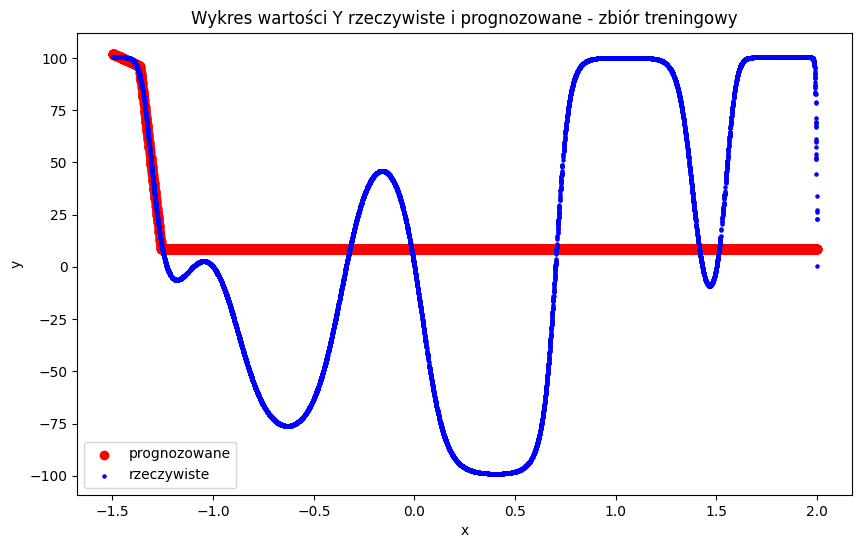

Train MSE =  4792.6919798255985
 Test MSE =  4807.562405452129


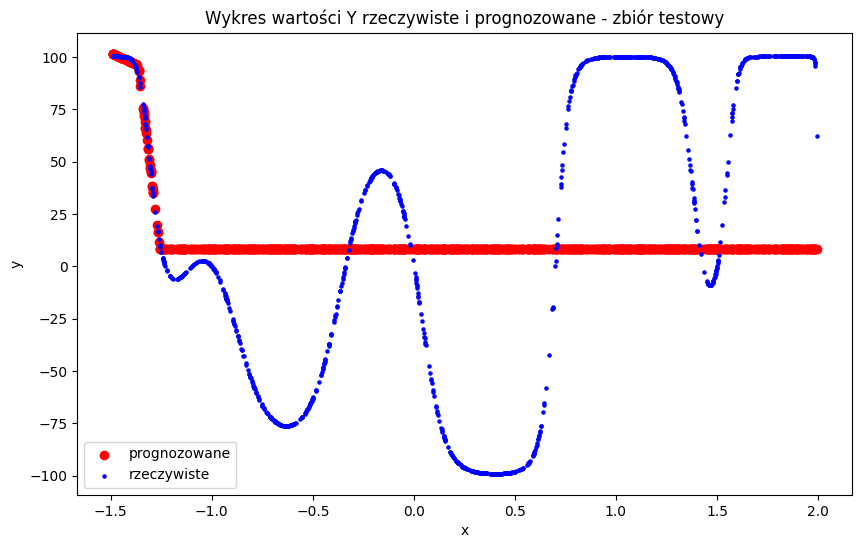

In [ ]:
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 64, 1] ,'relu')

mlp.fit(X, y_true,10000, 0.000001, 0, 0.9, 0, X_test, y_true_test, 0)

y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### 2 warstwa ukryta

#### sigmoid

Epoch 1/10000, Train Loss: 5354.9895215604665, Test Loss: 5398.870113187509
Epoch 1001/10000, Train Loss: 1501.5491305009857, Test Loss: 1650.3601296012046
Epoch 2001/10000, Train Loss: 1461.633188393499, Test Loss: 1606.3846062995624
Epoch 3001/10000, Train Loss: 1365.5138122403187, Test Loss: 1498.7460827255823
Epoch 4001/10000, Train Loss: 1267.9728840359032, Test Loss: 1388.2868553393018
Epoch 5001/10000, Train Loss: 1221.6795993565404, Test Loss: 1335.3651613423167
Epoch 6001/10000, Train Loss: 1197.4598285018806, Test Loss: 1307.4494788652542
Epoch 7001/10000, Train Loss: 1184.1081718296196, Test Loss: 1291.8983908484247
Epoch 8001/10000, Train Loss: 1176.2263757167689, Test Loss: 1282.5403361405272
Epoch 9001/10000, Train Loss: 1171.2049310518498, Test Loss: 1276.4229306248521


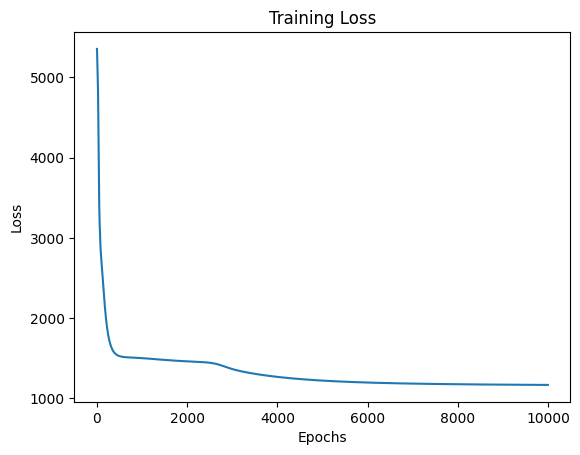

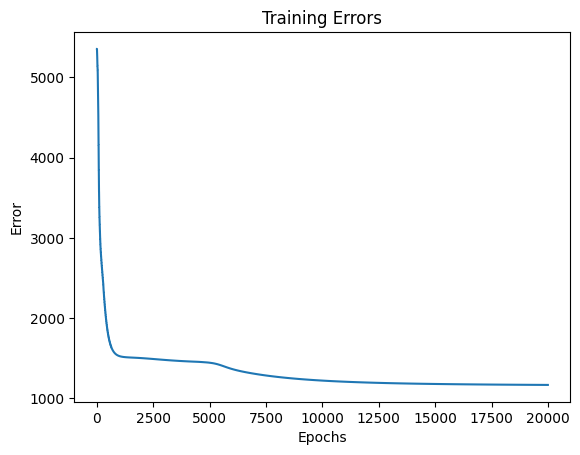

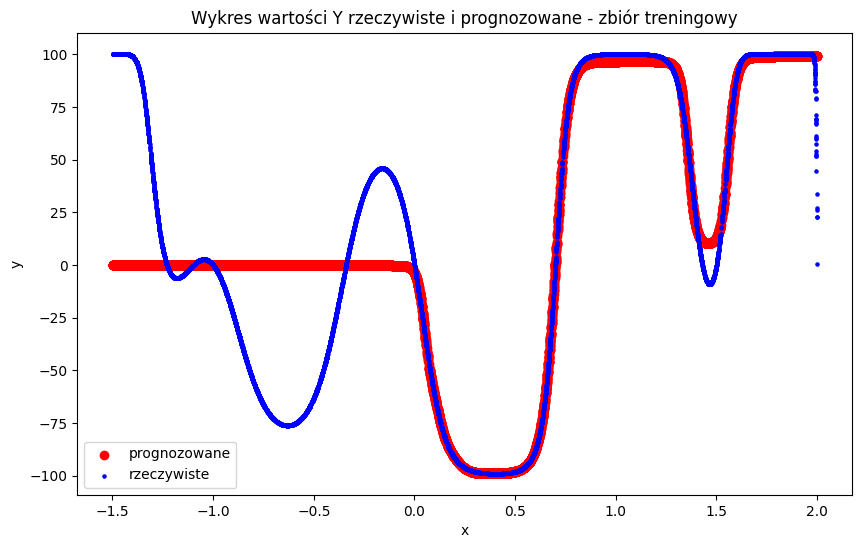

Train MSE =  1167.8500815380555
 Test MSE =  1272.2320105001959


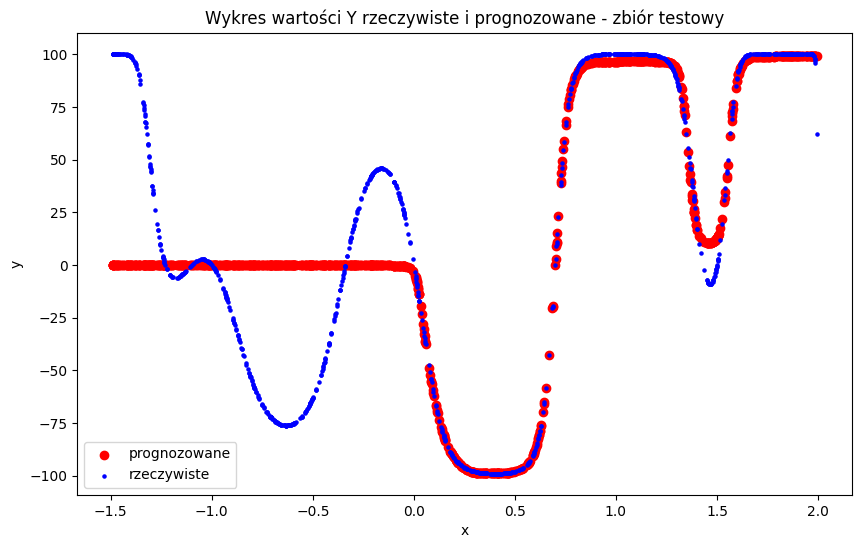

In [ ]:

df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 128, 64, 1] ,'sigmoid')

mlp.fit(X, y_true,10000, 0.0000001, 0, 0.9, 0, X_test, y_true_test, 0)

y_pred = mlp.predict(X,0)

    # def fit_batch(self, X, y, epochs=1000, learning_rate=0.01, er = 3, momentum=0, RMS = 0,X_test=None, y_test=None, norm = 0, batch_size=32):

# mlp.fit(X=X, y=y_true,epochs=1000000, learning_rate=0.000001, MSE=9, momentum=0,RMS=0, X_test=X_test, y_test=y_true_test)


mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)


y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# mlp.visualize_biases(0)
# mlp.visualize_biases(1)
# mlp.visualize_biases(2)
# mlp.visualize_weights(0)
# mlp.visualize_weights(1)
# mlp.visualize_weights(2)



#### linear

Epoch 1/10000, Train Loss: 5408.305545210086, Test Loss: 5168.359742459175
Epoch 1001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 2001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 3001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 4001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 5001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 6001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 7001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 8001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 9001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355


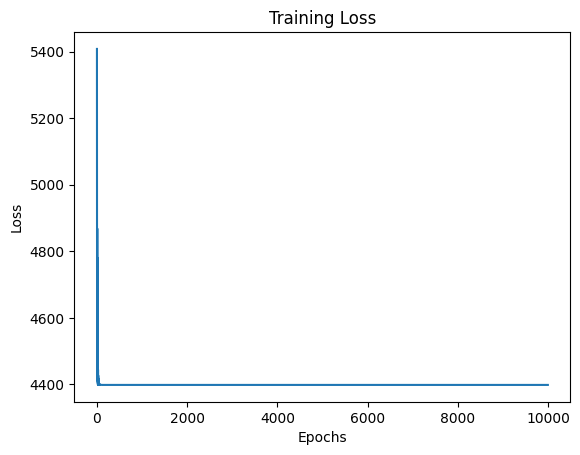

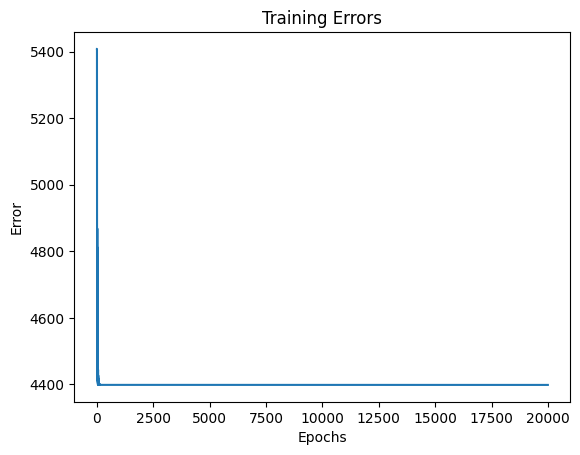

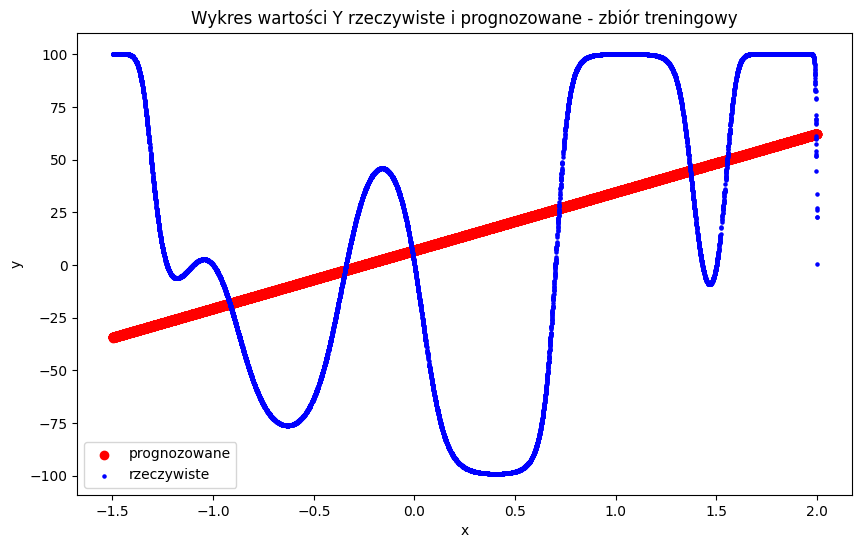

Train MSE =  4398.222171444738
 Test MSE =  4433.705680871355


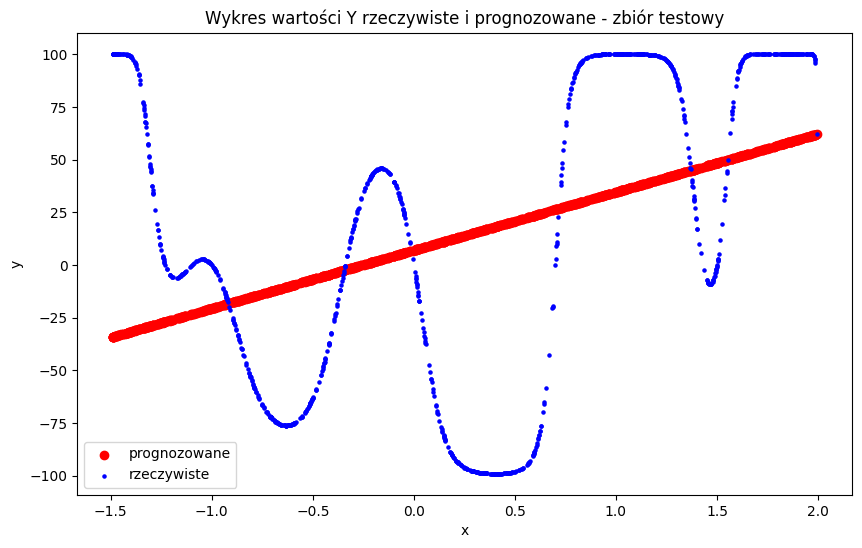

In [ ]:
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 128, 64, 1] ,'linear')

mlp.fit(X, y_true,10000, 0.00001, 0, 0.9, 0, X_test, y_true_test, 0)

y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### tanh

Epoch 1/10000, Train Loss: 5365.497597068014, Test Loss: 5369.607403064328
Epoch 1001/10000, Train Loss: 88.86433282837433, Test Loss: 100.24379538902453
Epoch 2001/10000, Train Loss: 79.54243872925599, Test Loss: 79.34427901669923
Epoch 3001/10000, Train Loss: 28.711670956004514, Test Loss: 32.025424279993565
Epoch 4001/10000, Train Loss: 18.87979455510419, Test Loss: 19.355472277498652
Epoch 5001/10000, Train Loss: 16.759303286808372, Test Loss: 18.205453166832303
Epoch 6001/10000, Train Loss: 18.29019045419654, Test Loss: 22.928201851770066
Epoch 7001/10000, Train Loss: 12.611888269858664, Test Loss: 18.23401862194562
Epoch 8001/10000, Train Loss: 15.197796170899897, Test Loss: 13.304889434632429
Epoch 9001/10000, Train Loss: 13.178741914954802, Test Loss: 13.089285644118434


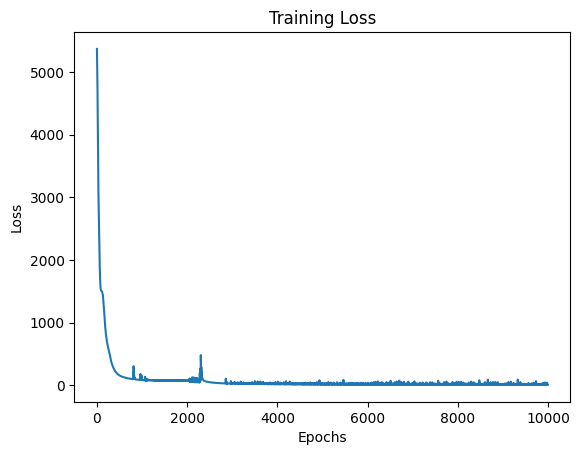

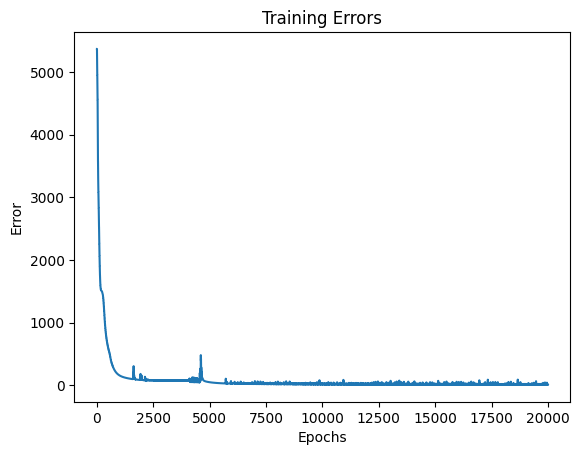

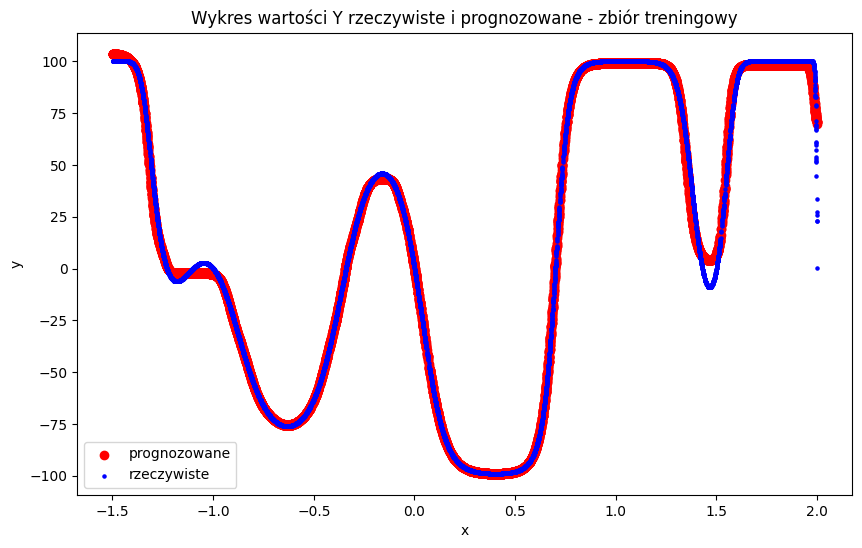

Train MSE =  11.601123235630133
 Test MSE =  12.273486283502905


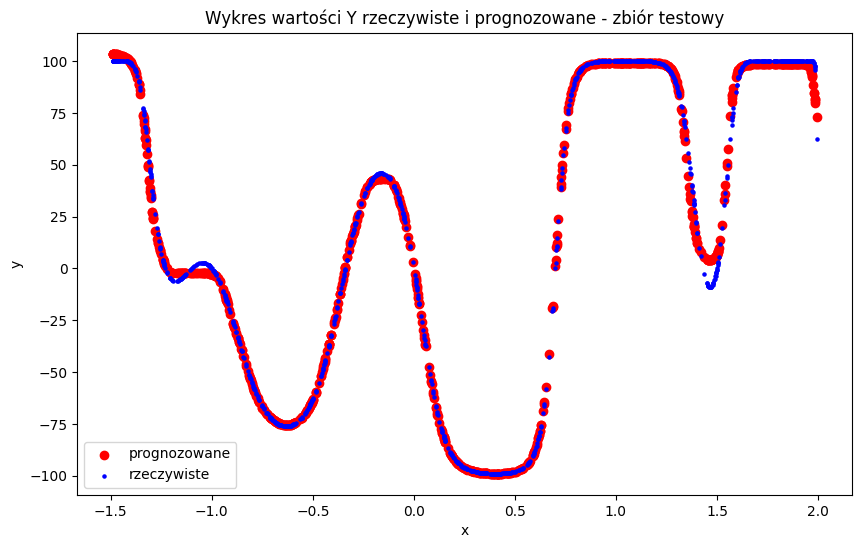

In [ ]:
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 128, 64, 1] ,'tanh')

mlp.fit(X, y_true,10000, 0.0000001, 0, 0.9, 0, X_test, y_true_test, 0)
y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### relu

Epoch 1/10000, Train Loss: 5363.4668399566535, Test Loss: 5341.064892117895
Epoch 1001/10000, Train Loss: 3941.10623938749, Test Loss: 3845.1307186288423
Epoch 2001/10000, Train Loss: 3940.555432120681, Test Loss: 3844.291976410538
Epoch 3001/10000, Train Loss: 3940.535546952033, Test Loss: 3844.263750473478
Epoch 4001/10000, Train Loss: 3940.530544745362, Test Loss: 3844.2535833109846
Epoch 5001/10000, Train Loss: 3940.526865460995, Test Loss: 3844.246213873649
Epoch 6001/10000, Train Loss: 3940.525292831334, Test Loss: 3844.2418273166904
Epoch 7001/10000, Train Loss: 3940.524326021816, Test Loss: 3844.2392456118705
Epoch 8001/10000, Train Loss: 3940.5235887331537, Test Loss: 3844.2369934018025
Epoch 9001/10000, Train Loss: 3940.5230172611236, Test Loss: 3844.2345692933523


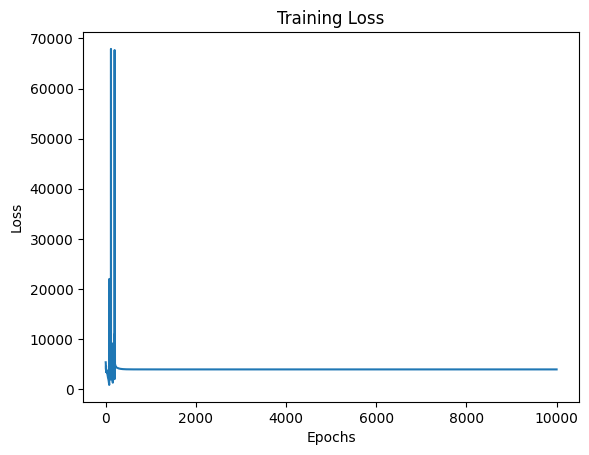

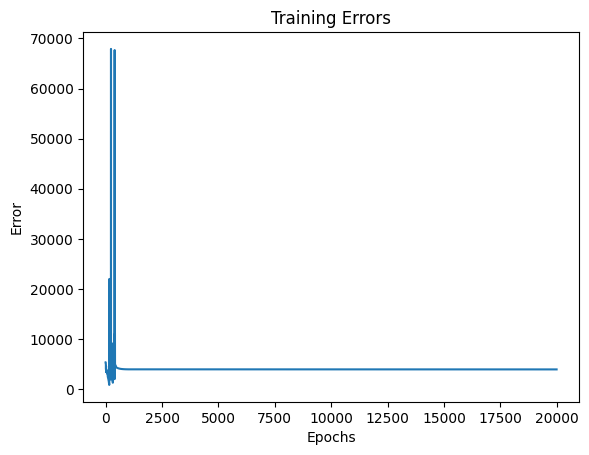

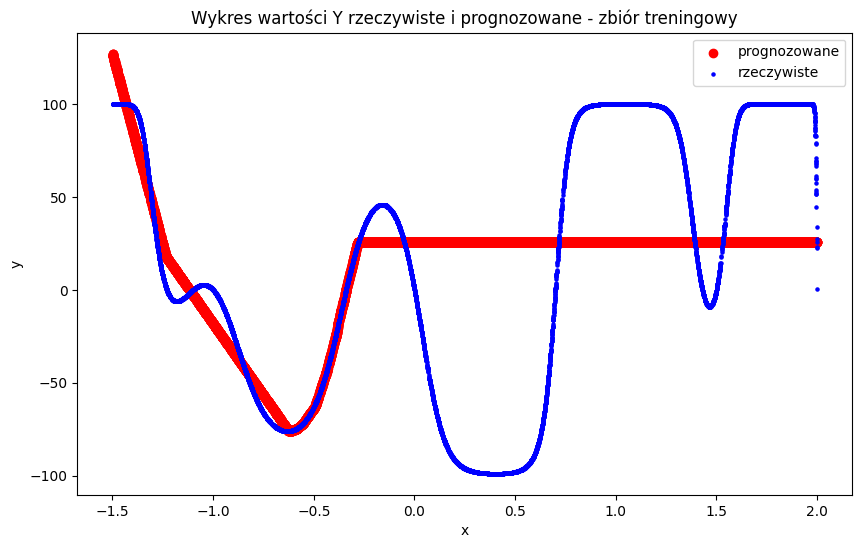

Train MSE =  3940.522510295076
 Test MSE =  3844.2336820895393


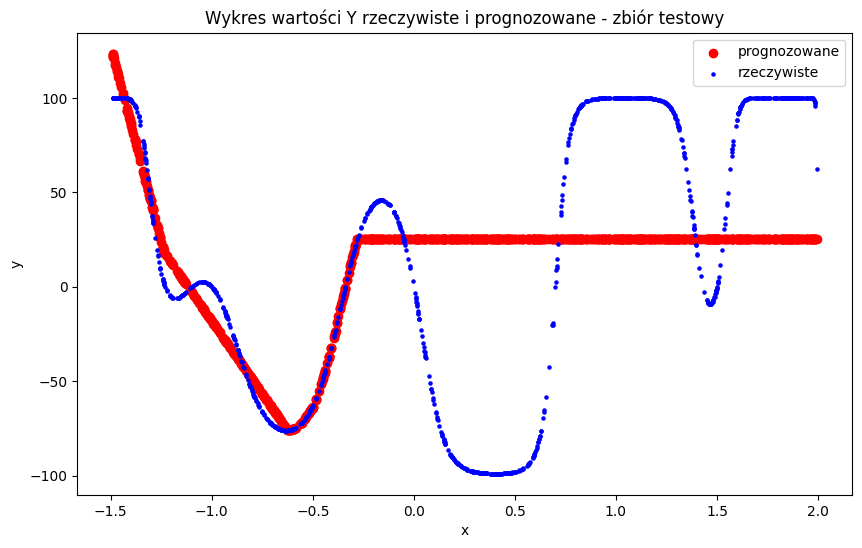

In [ ]:
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 128, 64, 1] ,'relu')

mlp.fit(X, y_true,10000, 0.0000001, 0, 0.9, 0, X_test, y_true_test, 0)
y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### 3 warstwa ukryta

#### sigmoid

Epoch 1/10000, Train Loss: 5360.439004969813, Test Loss: 5411.09891312314
Epoch 1001/10000, Train Loss: 2557.6284457425436, Test Loss: 2654.833479171411
Epoch 2001/10000, Train Loss: 1997.1969527272736, Test Loss: 2118.09244418121
Epoch 3001/10000, Train Loss: 1668.101899611901, Test Loss: 1803.428552672985
Epoch 4001/10000, Train Loss: 1559.6057269107355, Test Loss: 1701.3131087650072
Epoch 5001/10000, Train Loss: 1524.209828009279, Test Loss: 1669.3476592643253
Epoch 6001/10000, Train Loss: 1511.0853288853211, Test Loss: 1658.1757441314012
Epoch 7001/10000, Train Loss: 1505.9572933058862, Test Loss: 1654.019122971366
Epoch 8001/10000, Train Loss: 1503.3368379140265, Test Loss: 1651.8810027992056
Epoch 9001/10000, Train Loss: 1500.7762956583601, Test Loss: 1649.4749561404676


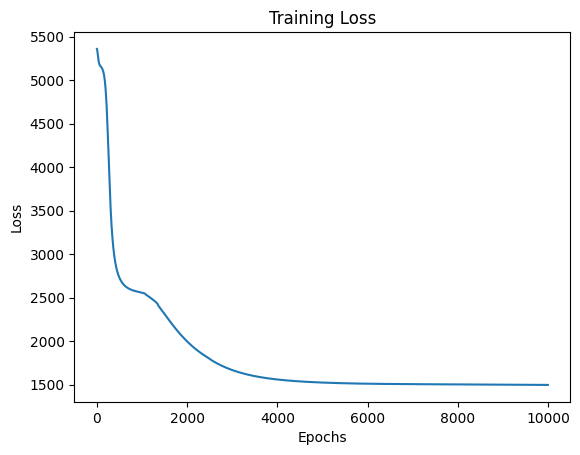

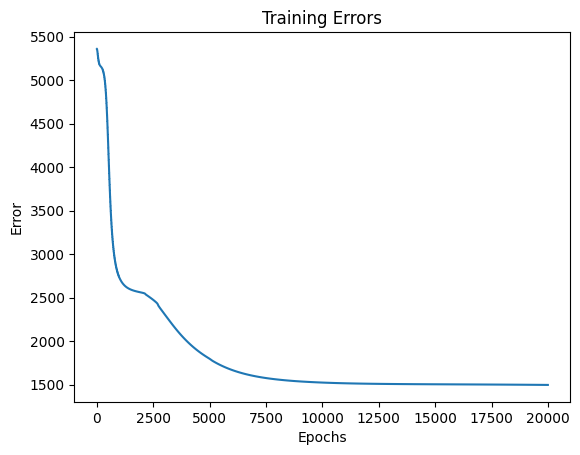

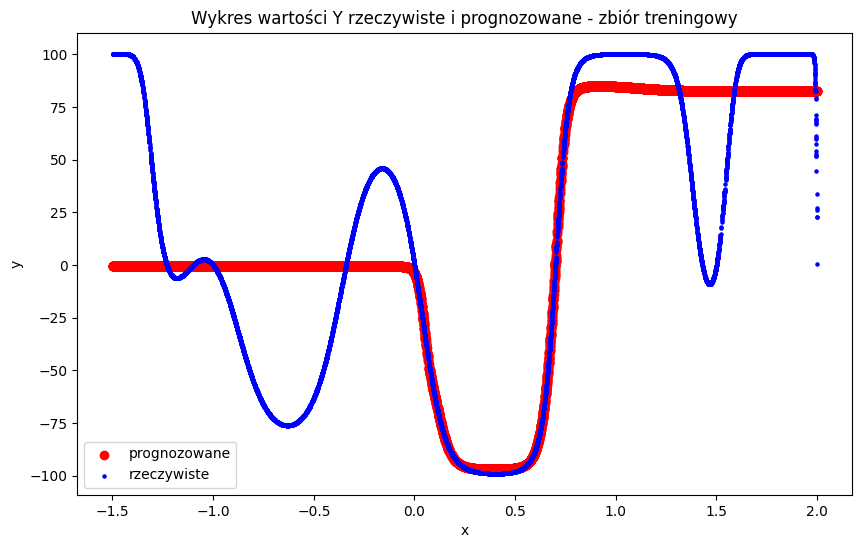

Train MSE =  1497.1747768726295
 Test MSE =  1645.7265244997343


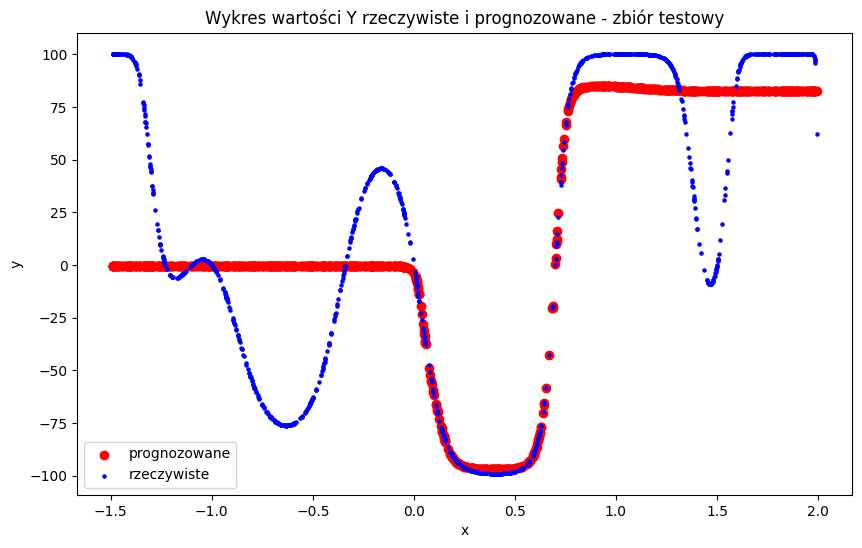

In [ ]:
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 256, 128, 64, 1] ,'sigmoid')

mlp.fit(X, y_true,10000, 0.00000001, 0, 0.9, 0, X_test, y_true_test, 0)
y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### linear

Epoch 1/10000, Train Loss: 5408.305545210086, Test Loss: 5168.359742459175
Epoch 1001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 2001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 3001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 4001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 5001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 6001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 7001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 8001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355
Epoch 9001/10000, Train Loss: 4398.222171444738, Test Loss: 4433.705680871355


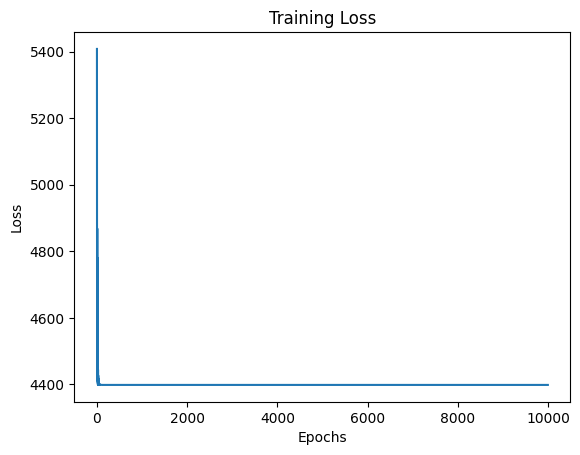

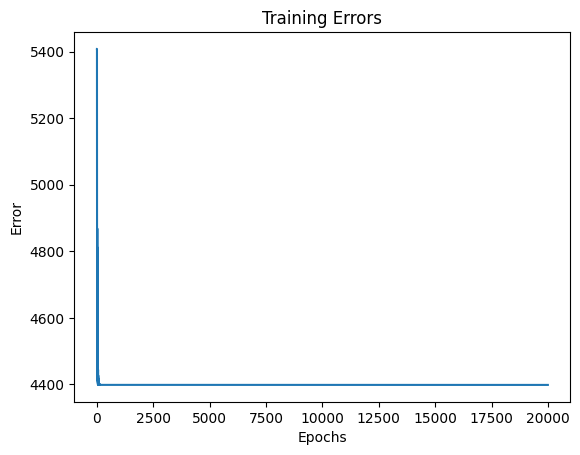

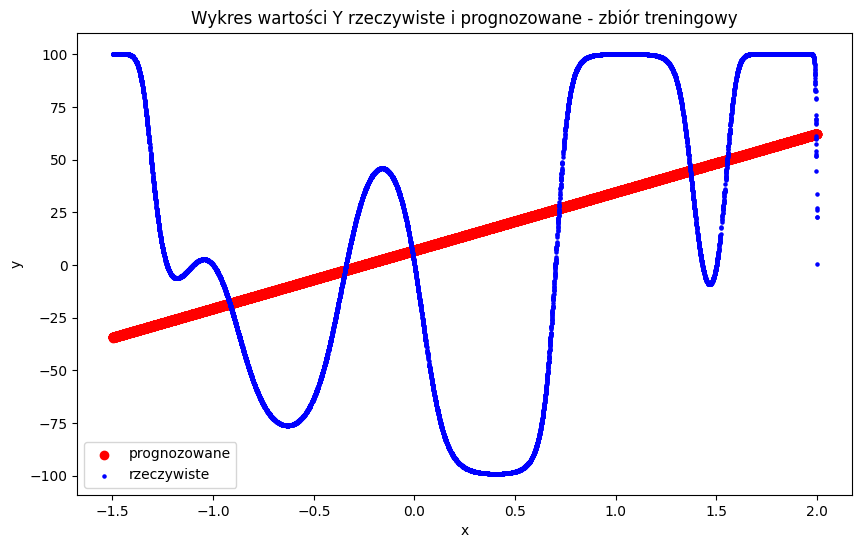

Train MSE =  4398.222171444738
 Test MSE =  4433.705680871355


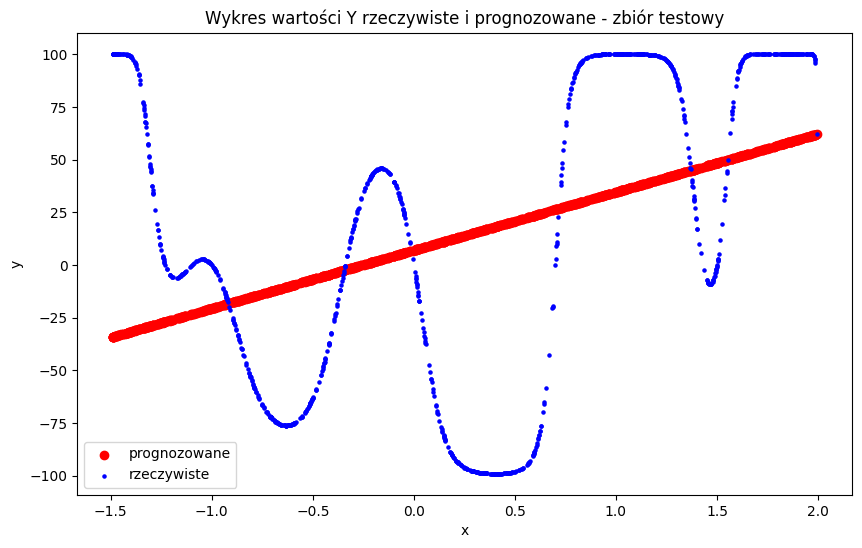

In [ ]:
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 256, 128, 64, 1] ,'linear')

mlp.fit(X, y_true,10000, 0.00001, 0, 0.9, 0, X_test, y_true_test, 0)

y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### tanh

Epoch 1/10000, Train Loss: 5314.332363623792, Test Loss: 5354.861420958606
Epoch 1001/10000, Train Loss: 1645.3604016501115, Test Loss: 1784.6536583190118
Epoch 2001/10000, Train Loss: 1205.8836421481342, Test Loss: 1309.221119074498
Epoch 3001/10000, Train Loss: 1078.25189766095, Test Loss: 1167.2027651807907
Epoch 4001/10000, Train Loss: 925.3824652918541, Test Loss: 995.0838942426371
Epoch 5001/10000, Train Loss: 828.255799832367, Test Loss: 885.549785692384
Epoch 6001/10000, Train Loss: 761.1441962297722, Test Loss: 810.3294671655768
Epoch 7001/10000, Train Loss: 713.2917610570873, Test Loss: 757.1482194428057
Epoch 8001/10000, Train Loss: 678.2494247513785, Test Loss: 718.4145145812438
Epoch 9001/10000, Train Loss: 652.0419226483127, Test Loss: 689.4956774130338


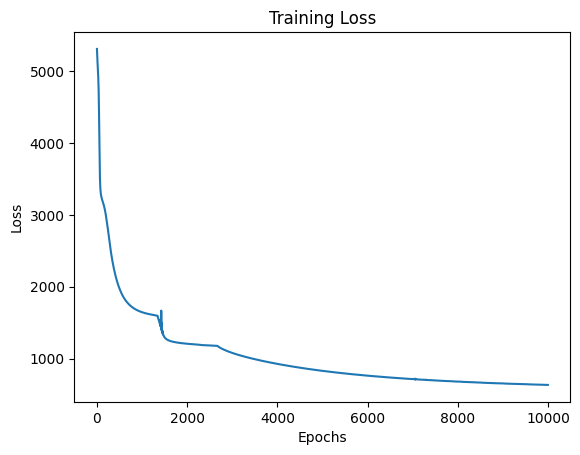

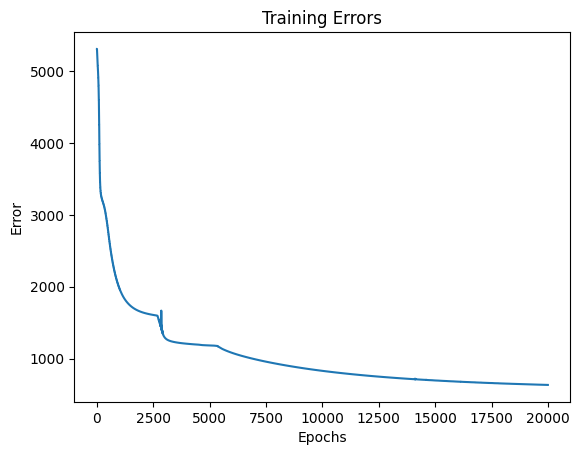

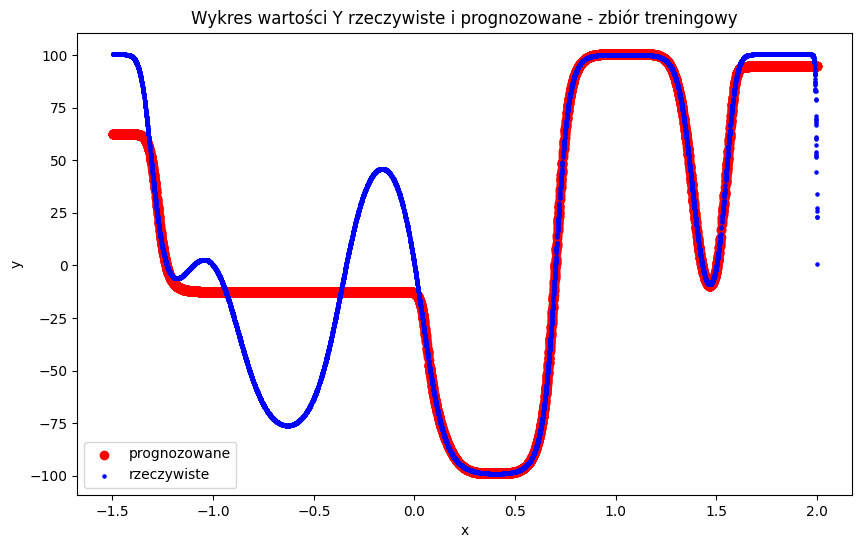

Train MSE =  632.2669140864174
 Test MSE =  667.6381582851578


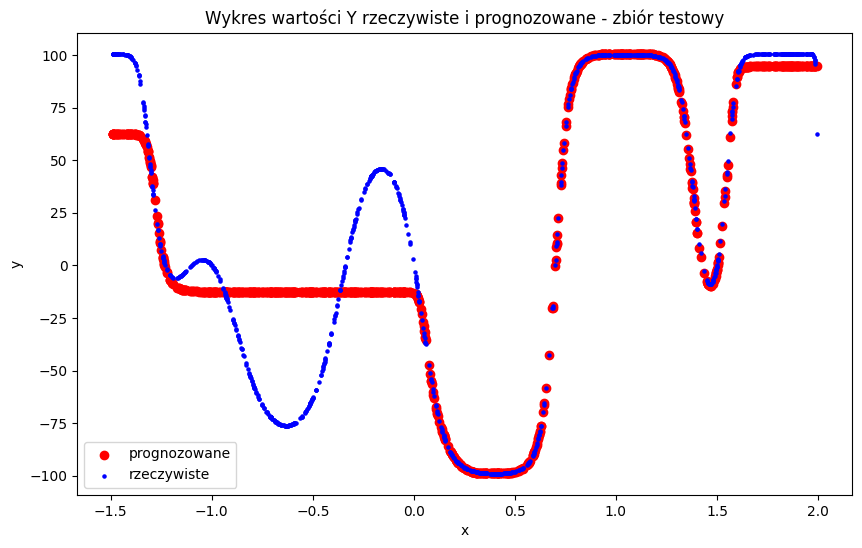

In [ ]:
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 256, 128, 64, 1] ,'tanh')

mlp.fit(X, y_true,10000, 0.00000001, 0, 0.9, 0, X_test, y_true_test, 0)
y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### relu

Epoch 1/10000, Train Loss: 5330.212470631344, Test Loss: 5369.70044234454
Epoch 1001/10000, Train Loss: 135.38172977629063, Test Loss: 139.58951443734583
Epoch 2001/10000, Train Loss: 116.760408954407, Test Loss: 120.29996562246153
Epoch 3001/10000, Train Loss: 23.95599424075318, Test Loss: 20.47073860187512
Epoch 4001/10000, Train Loss: 7.4031770733390845, Test Loss: 3.27226094662438
Epoch 5001/10000, Train Loss: 6.5399804128361865, Test Loss: 2.3842352000262306
Epoch 6001/10000, Train Loss: 6.2257911867652975, Test Loss: 2.087944192946183
Epoch 7001/10000, Train Loss: 6.050282788586318, Test Loss: 1.9650691064628045
Epoch 8001/10000, Train Loss: 5.934543579611632, Test Loss: 1.917290814222046
Epoch 9001/10000, Train Loss: 18.034519301626464, Test Loss: 14.573536199371226


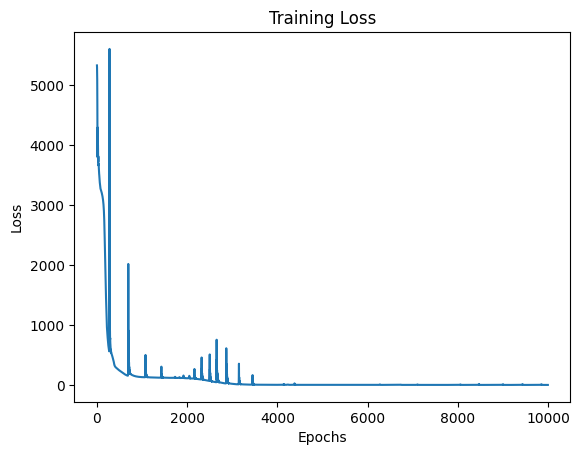

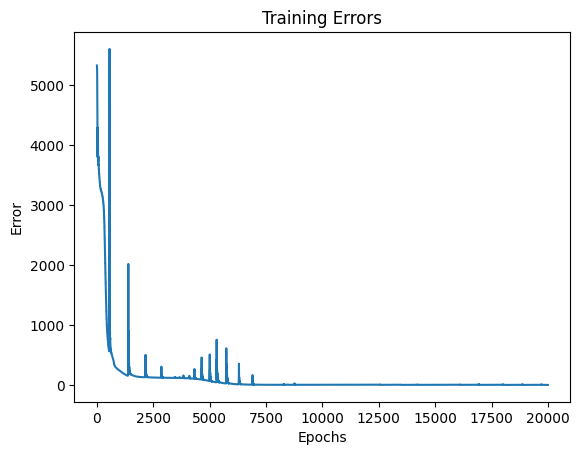

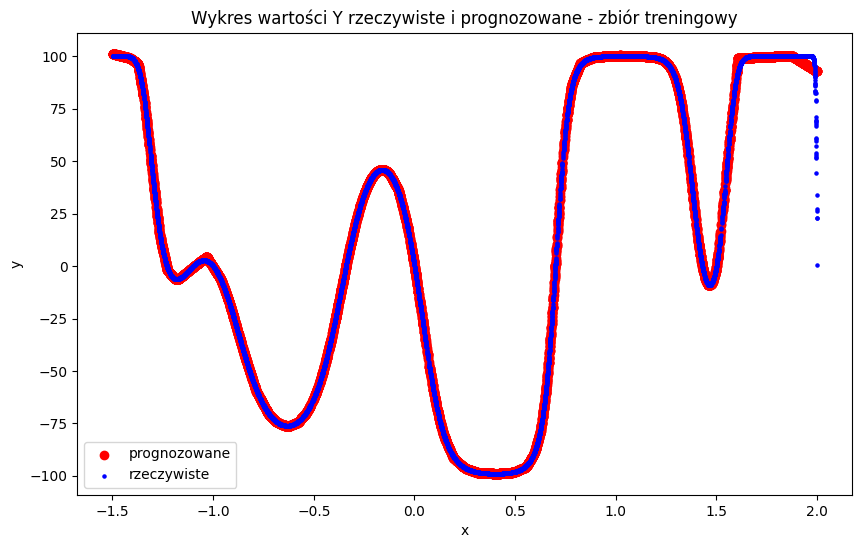

Train MSE =  5.624661723591437
 Test MSE =  1.831322347817923


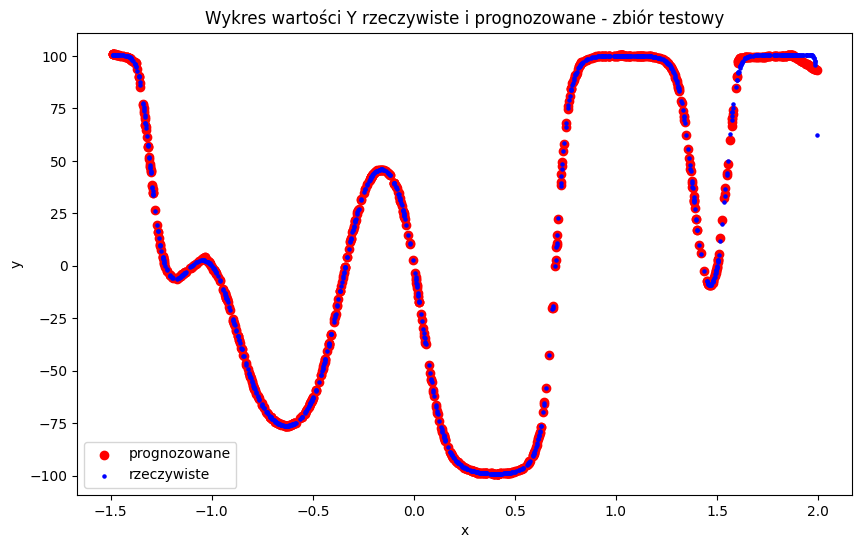

In [ ]:
df = pd.read_csv('mio1/regression/multimodal-large-training.csv')
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/multimodal-large-test.csv')
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 256, 128, 64, 1] ,'relu')

mlp.fit(X, y_true,10000, 0.00000001, 0, 0.9, 0, X_test, y_true_test, 0)
y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Tabela przedstawia wartości średniego błędu kwadratowego (MSE) na zbiorze testowym dla modelu uczonego na zbiorze multimodal przez 10 000 epok. Porównano różne funkcje aktywacji (Sigmoid, Linear, Tanh, ReLU) oraz różne liczby warstw w sieci neuronowej (1, 2, i 3 warstwy).
| Ilość warstw \ Funkcja aktywacji | Sigmoid  | Linear   | Tanh    | ReLU    |
|----------------------------------|----------|----------|---------|---------|
| 1                                | 2.23     | 4433.71  | 1.84    | 4807.56 |
| 2                                | 1272.23  | 4433.71  | 12.27   | 3844.23 |
| 3                                | 1645.73  | 4433.71  | 667.64  | 1.83    |


## Zbiór steps large

Epoch 1/10000, Train Loss: 7351.776643046328, Test Loss: 7226.582932659931
Epoch 1001/10000, Train Loss: 39.02722554997861, Test Loss: 33.96342476962361
Epoch 2001/10000, Train Loss: 9.928156544197906, Test Loss: 6.143179354308674
Epoch 3001/10000, Train Loss: 15.44922418429536, Test Loss: 12.82291954220628
Epoch 4001/10000, Train Loss: 20.587380306676764, Test Loss: 20.039094164515145
Epoch 5001/10000, Train Loss: 25.670577211310615, Test Loss: 23.74446267112848
Epoch 6001/10000, Train Loss: 6.750888883559727, Test Loss: 9.698687245988028
Epoch 7001/10000, Train Loss: 3.326742303716094, Test Loss: 4.743291906720533
Epoch 8001/10000, Train Loss: 2.565878570802931, Test Loss: 4.594691069306859
Epoch 9001/10000, Train Loss: 1.9004993220780277, Test Loss: 4.478933670097975


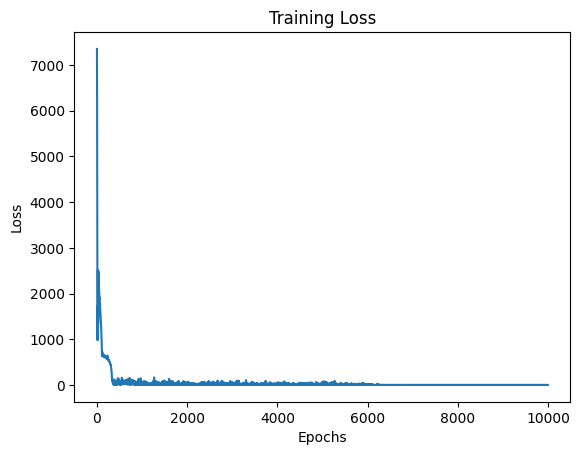

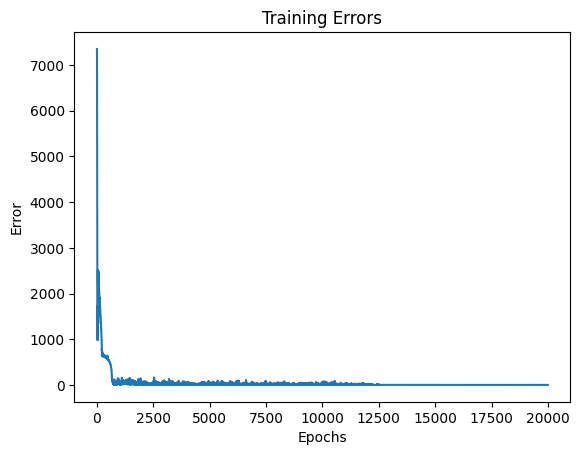

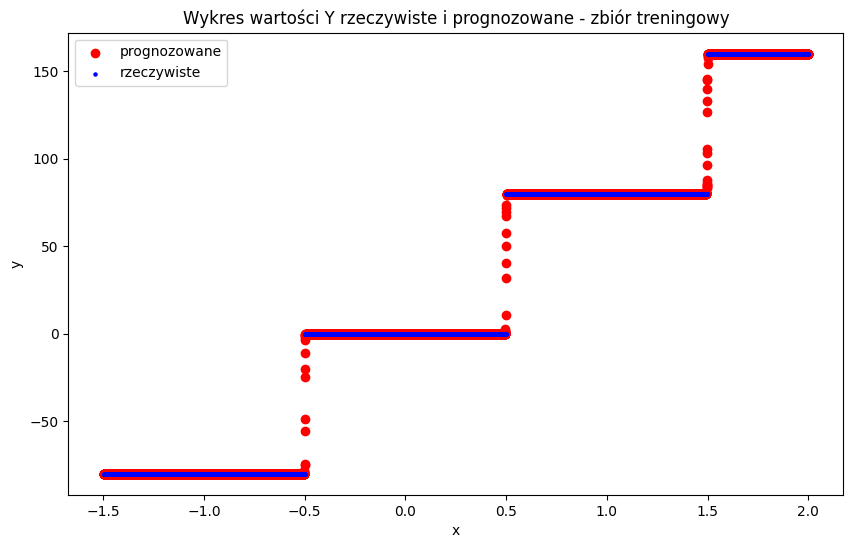

Train MSE =  3.2033718416151555
 Test MSE =  0.4852818186661316


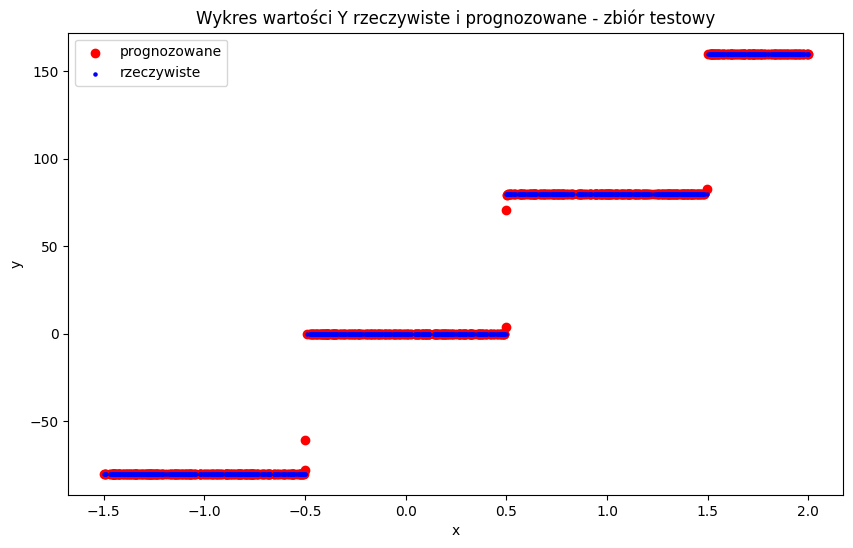

In [ ]:
df = pd.read_csv('mio1/regression/steps-large-training.csv', index_col=0)
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/steps-large-test.csv', index_col=0)
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 5,5, 1] ,'tanh')

mlp.fit(X, y_true,10000, 0.000001, 0, 0.9, 0, X_test, y_true_test, 0)

y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Epoch 1/10000, Train Loss: 7370.550535993212, Test Loss: 7417.453842894295
Epoch 1001/10000, Train Loss: 18.468714300869678, Test Loss: 13.619027571685681
Epoch 2001/10000, Train Loss: 12.985891995353725, Test Loss: 9.487309362617983
Epoch 3001/10000, Train Loss: 10.473245419727524, Test Loss: 7.793660656990233
Epoch 4001/10000, Train Loss: 8.936482388889717, Test Loss: 6.829130736330881
Epoch 5001/10000, Train Loss: 7.855059690948826, Test Loss: 6.136076688282734
Epoch 6001/10000, Train Loss: 7.055105046844026, Test Loss: 5.603970969762495
Epoch 7001/10000, Train Loss: 6.4453462880540755, Test Loss: 5.183112124260401
Epoch 8001/10000, Train Loss: 5.968312177962555, Test Loss: 4.842546093295446
Epoch 9001/10000, Train Loss: 5.586040347964936, Test Loss: 4.561460589663495


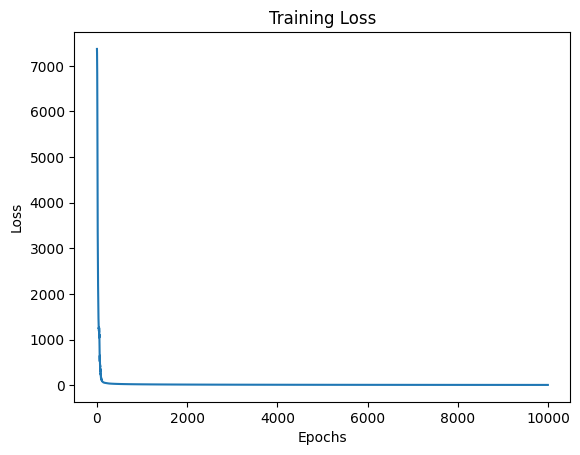

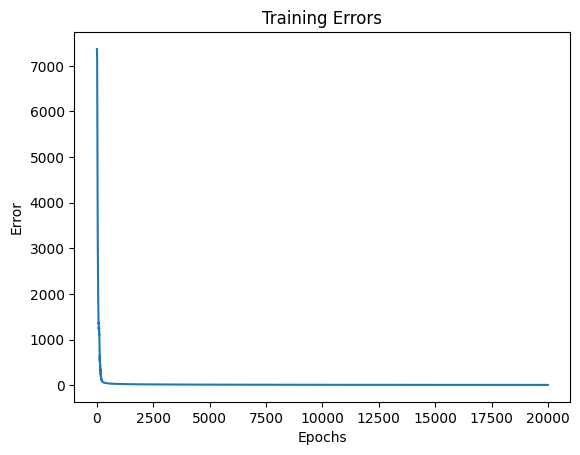

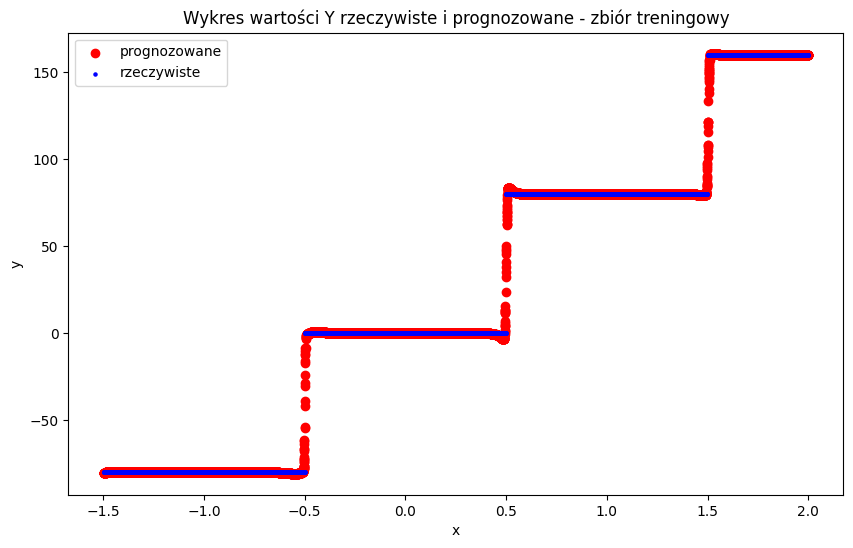

Train MSE =  5.272967102691617
 Test MSE =  4.684977012750103


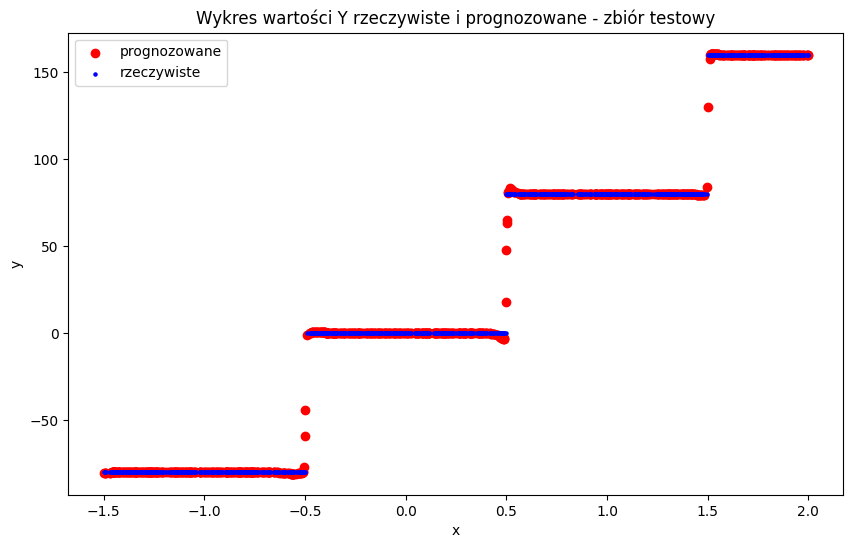

In [ ]:
df = pd.read_csv('mio1/regression/steps-large-training.csv', index_col=0)
X=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true=df.iloc[:,1].to_numpy().reshape(-1,1)

df = pd.read_csv('mio1/regression/steps-large-test.csv', index_col=0)
X_test=df.iloc[:,0].to_numpy().reshape(-1,1)
y_true_test=df.iloc[:,1].to_numpy().reshape(-1,1)
mlp = MLP( [1, 5,5, 1] ,'sigmoid')

mlp.fit(X, y_true,10000, 0.000001, 0, 0.9, 0, X_test, y_true_test, 0)

y_pred = mlp.predict(X,0)

mse_error = mlp.mse(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_pred, label='prognozowane', color='red')
plt.scatter(X, y_true, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór treningowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("Train MSE = ", mse_error)

y_pred = mlp.predict(X_test,0)
mse_error = mlp.mse(y_true_test, y_pred)
print(" Test MSE = ", mse_error)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, label='prognozowane', color='red')
plt.scatter(X_test, y_true_test, label='rzeczywiste', color='blue', s=5)
plt.title('Wykres wartości Y rzeczywiste i prognozowane - zbiór testowy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Najlepsze konfiguracje dla zbioru steps large to:
- dwie warstwy ukryte + tanh - test mse = 0.49
- dwie warstwy ukryte + sigmoid - test mse = 4.68

## Zbiór rings3 regular

Epoch 1/10000, Train Loss: 0.16666666541500003, Error: 3.926263150285384
Epoch 1001/10000, Train Loss: 0.5479206331492478, Error: 0.8900671462107961
Epoch 2001/10000, Train Loss: 0.5566648399740948, Error: 0.8629178080097463
Epoch 3001/10000, Train Loss: 0.5892841218371508, Error: 0.8061724469473105
Epoch 4001/10000, Train Loss: 0.6925234231581725, Error: 0.6558986652941916
Epoch 5001/10000, Train Loss: 0.7774300442007895, Error: 0.5372208345947517
Epoch 6001/10000, Train Loss: 0.7854187392417437, Error: 0.49179983123250715
Epoch 7001/10000, Train Loss: 0.7857395946457014, Error: 0.4715765207033298
Epoch 8001/10000, Train Loss: 0.7840725361833213, Error: 0.4761272639384943
Epoch 9001/10000, Train Loss: 0.7859478521895819, Error: 0.4691729388860284


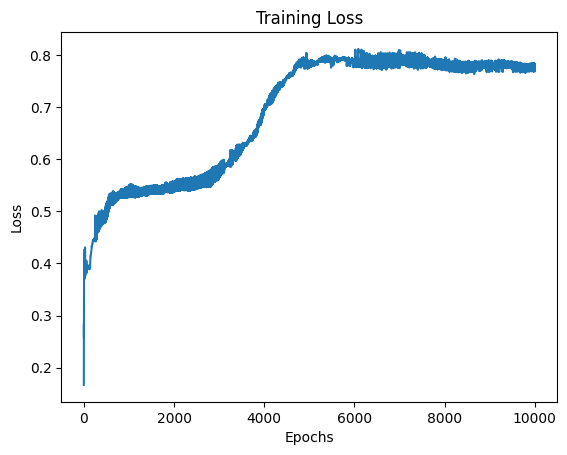

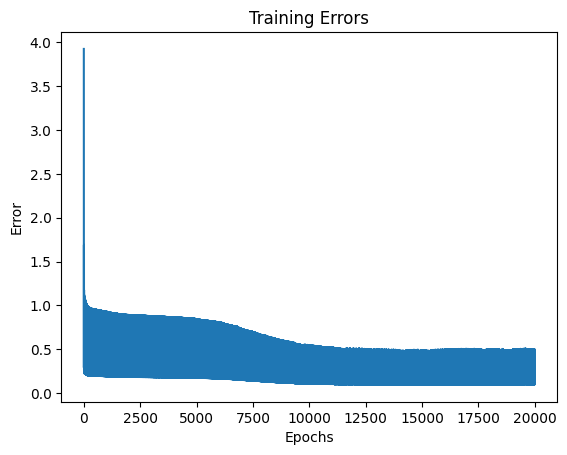

Train F-measure:  0.7857659833215975
Test F-measure:  0.7716986691429923


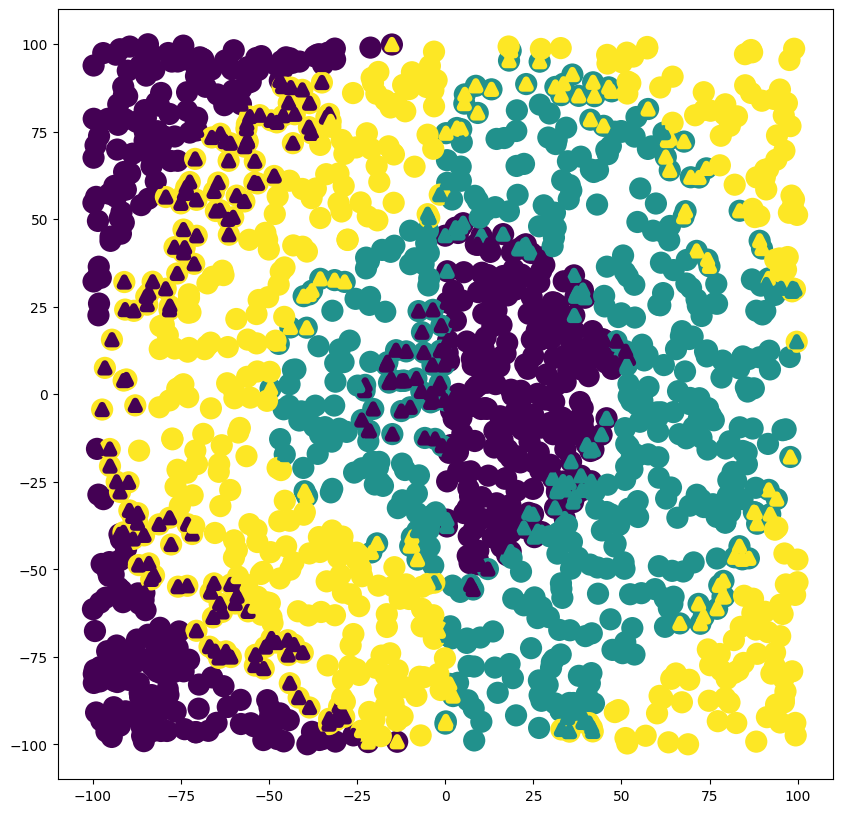

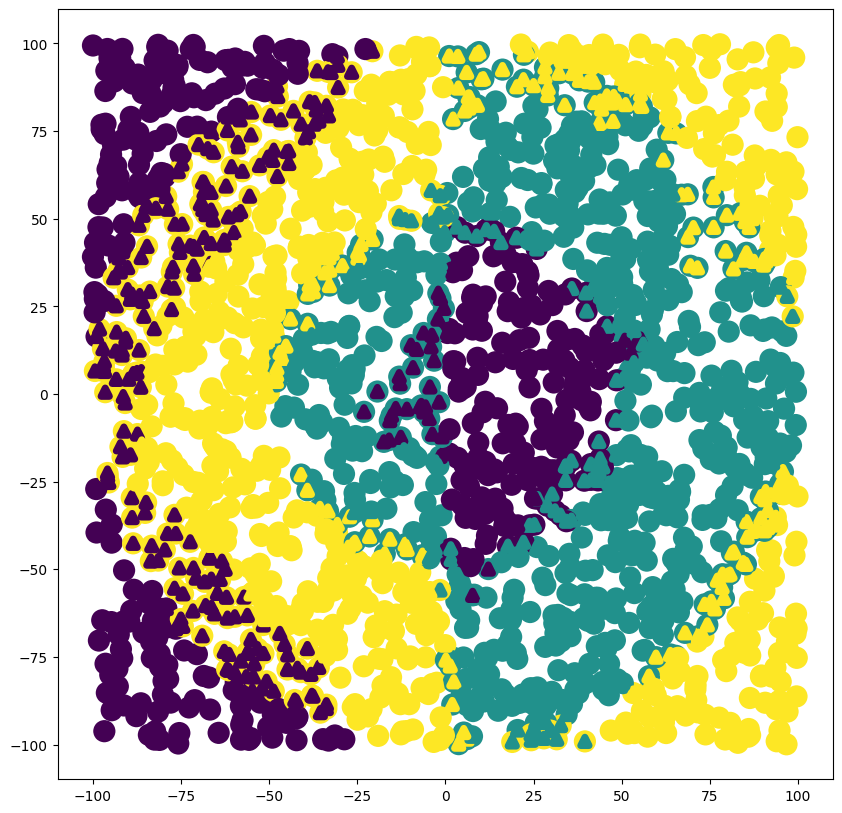

In [ ]:
df = pd.read_csv('mio1/classification/rings3-regular-training.csv')
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true = one_hot_encode(y, 3)
mlp = MLP([2,8,6,4,3], 'relu', 'softmax', "cross-entropy")
mlp.fit(X, y_true,10000, 0.00001, 1)
y_prob = mlp.predict(X,0)
y_pred =mlp.softmax_to_one_hot(y_prob)
y_pred_col = mlp.convert_to_class_indices(y_pred)
F = mlp.f1_score(y_pred=y_pred, y_true=y_true)
print("Train F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_col, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=2)

df = pd.read_csv('mio1/classification/rings3-regular-test.csv')
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true_test = one_hot_encode(y_test, 3)

y_prob_test = mlp.predict(X_test,0)
y_pred_test = mlp.softmax_to_one_hot(y_prob_test)
y_pred_col_test = mlp.convert_to_class_indices(y_pred_test)
F = mlp.f1_score(y_pred=y_pred_test, y_true=y_true_test)
print("Test F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_col_test, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=2)


Epoch 1/10000, Train Loss: 0.37070386801842375, Error: 1.2781266605330117
Epoch 1001/10000, Train Loss: 0.5291365578100419, Error: 0.9525501876709765
Epoch 2001/10000, Train Loss: 0.5908384354206203, Error: 0.8892958565266432
Epoch 3001/10000, Train Loss: 0.5554140721185727, Error: 0.9317420922584648
Epoch 4001/10000, Train Loss: 0.5851304809375772, Error: 0.881318479443229
Epoch 5001/10000, Train Loss: 0.5922658776952034, Error: 0.8635878529706938
Epoch 6001/10000, Train Loss: 0.5837718565774789, Error: 0.8924399840462444
Epoch 7001/10000, Train Loss: 0.6243164068082873, Error: 0.7976773171833877
Epoch 8001/10000, Train Loss: 0.6578989588224701, Error: 0.7275495737480875
Epoch 9001/10000, Train Loss: 0.6753839002042993, Error: 0.7037764842251495


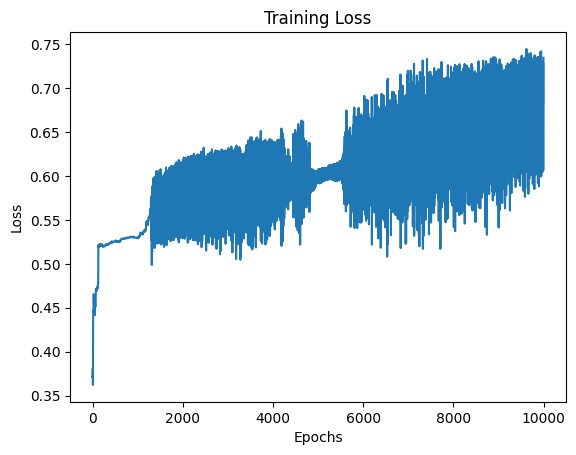

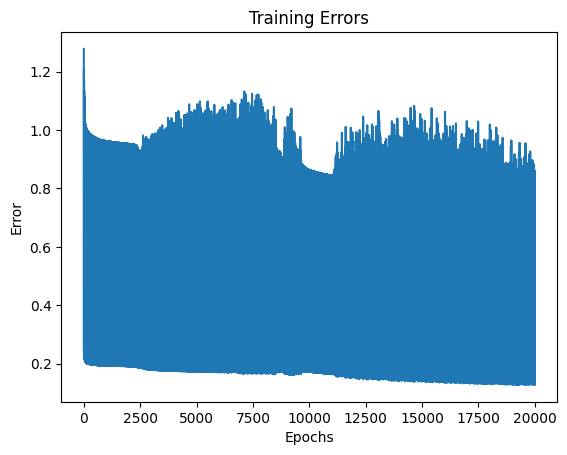

Train F-measure:  0.7299893672839012
Test F-measure:  0.6807863392467509


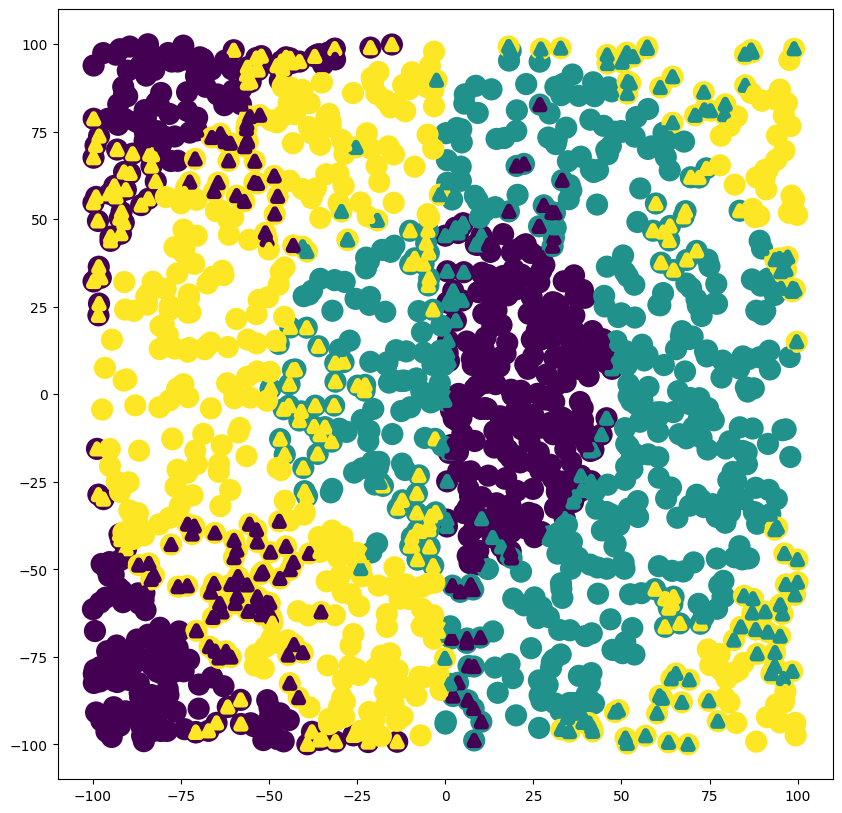

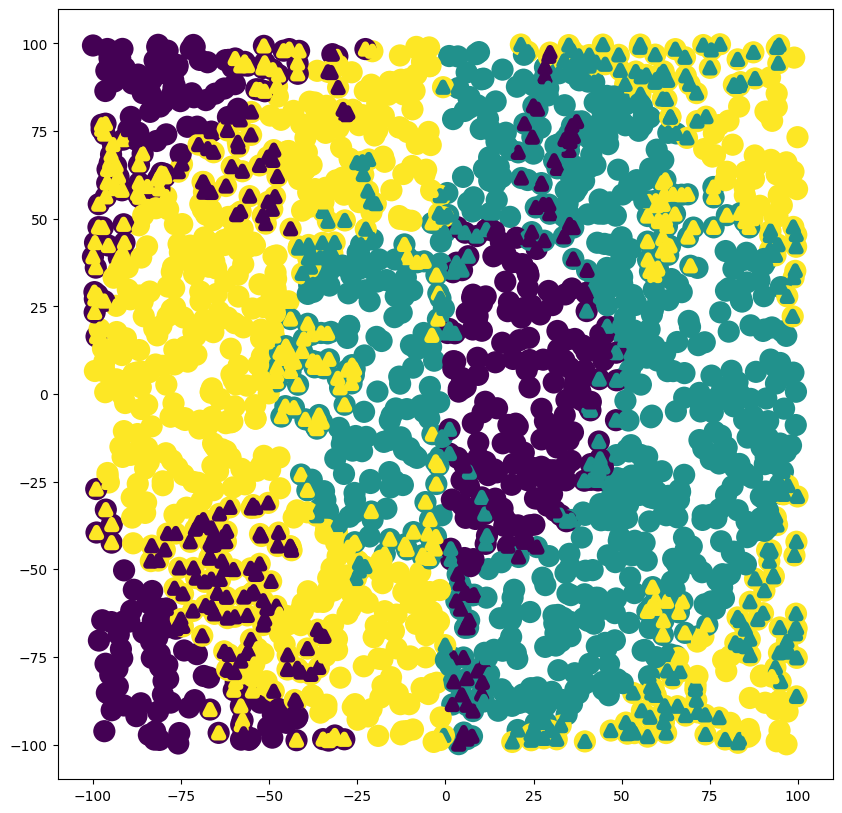

In [ ]:
df = pd.read_csv('mio1/classification/rings3-regular-training.csv')
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true = one_hot_encode(y, 3)
mlp = MLP([2,32,3], 'tanh', 'softmax', "cross-entropy")
mlp.fit(X, y_true,10000, 0.00001, 1)
y_prob = mlp.predict(X,0)
y_pred =mlp.softmax_to_one_hot(y_prob)
y_pred_col = mlp.convert_to_class_indices(y_pred)
F = mlp.f1_score(y_pred=y_pred, y_true=y_true)
print("Train F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_col, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=2)

df = pd.read_csv('mio1/classification/rings3-regular-test.csv')
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true_test = one_hot_encode(y_test, 3)

y_prob_test = mlp.predict(X_test,0)
y_pred_test = mlp.softmax_to_one_hot(y_prob_test)
y_pred_col_test = mlp.convert_to_class_indices(y_pred_test)
F = mlp.f1_score(y_pred=y_pred_test, y_true=y_true_test)
print("Test F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_col_test, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=2)

Najlepsze konfiguracje dla zbioru rings3 regular to:
- trzy warstwy ukryte + relu - test f-measure = 0.77
- jedna warstwa ukryta + tanh - test f-measure = 0.68

## Zbiór rings5 regular

Epoch 1/10000, Train Loss: 0.1474333996750911, Error: 17.321655301439176
Epoch 1001/10000, Train Loss: 0.5085907957020654, Error: 0.9597142979307135
Epoch 2001/10000, Train Loss: 0.5982134279654285, Error: 0.8883117688776317
Epoch 3001/10000, Train Loss: 0.6608104348956028, Error: 0.8572011906108897
Epoch 4001/10000, Train Loss: 0.6700471400876816, Error: 0.8078283182611066
Epoch 5001/10000, Train Loss: 0.7104647667646734, Error: 0.7907492093146791
Epoch 6001/10000, Train Loss: 0.7277332358195152, Error: 0.7546604289686725
Epoch 7001/10000, Train Loss: 0.71717508966795, Error: 0.727834701093469
Epoch 8001/10000, Train Loss: 0.7208966313795167, Error: 0.7278085738126698
Epoch 9001/10000, Train Loss: 0.7637775875637779, Error: 0.6921694016170835


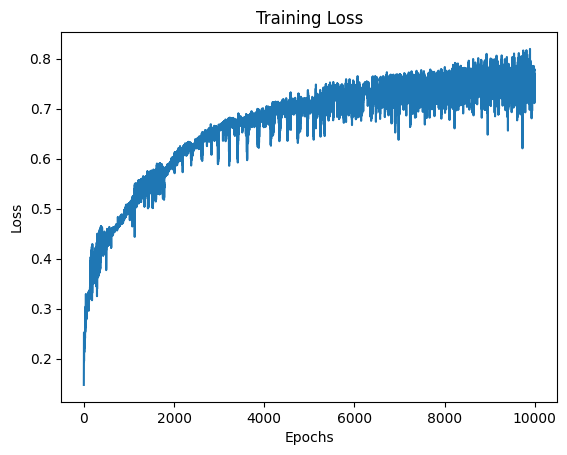

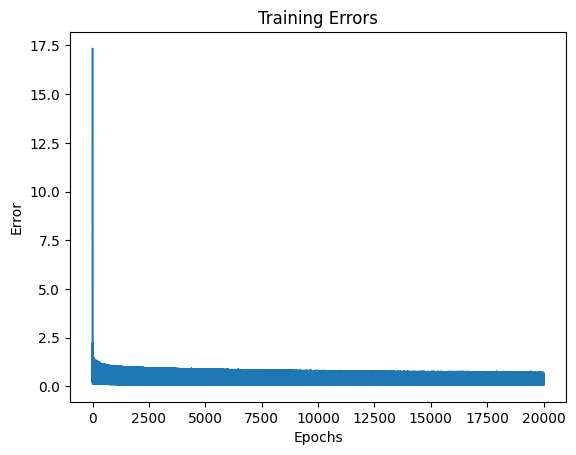

Train F-measure:  0.7741600991654518
Test F-measure:  0.6245067991548321


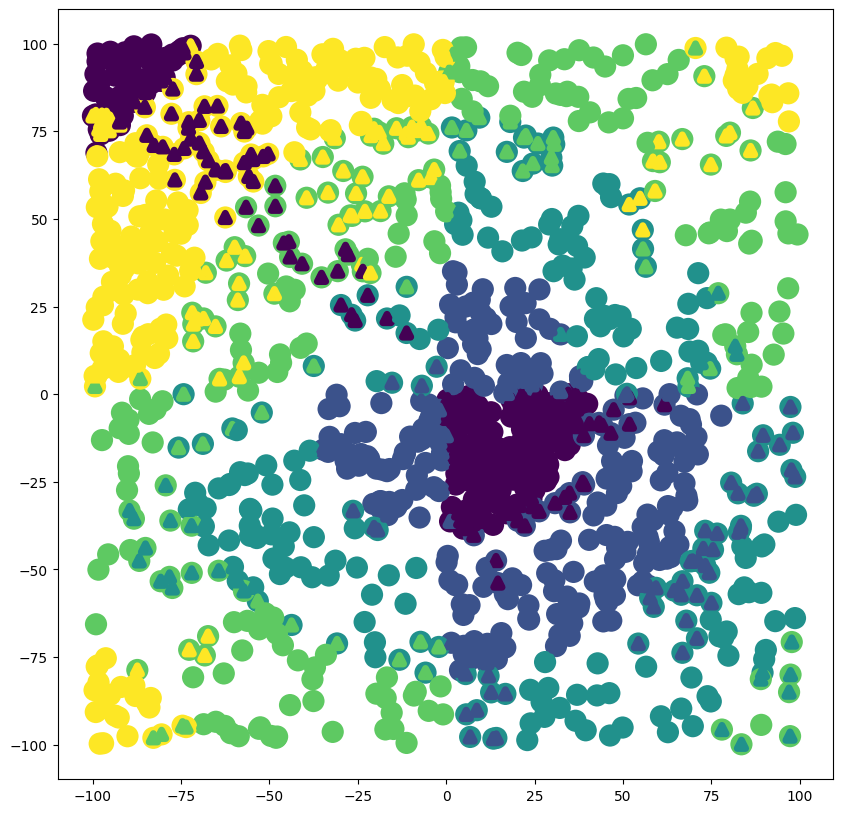

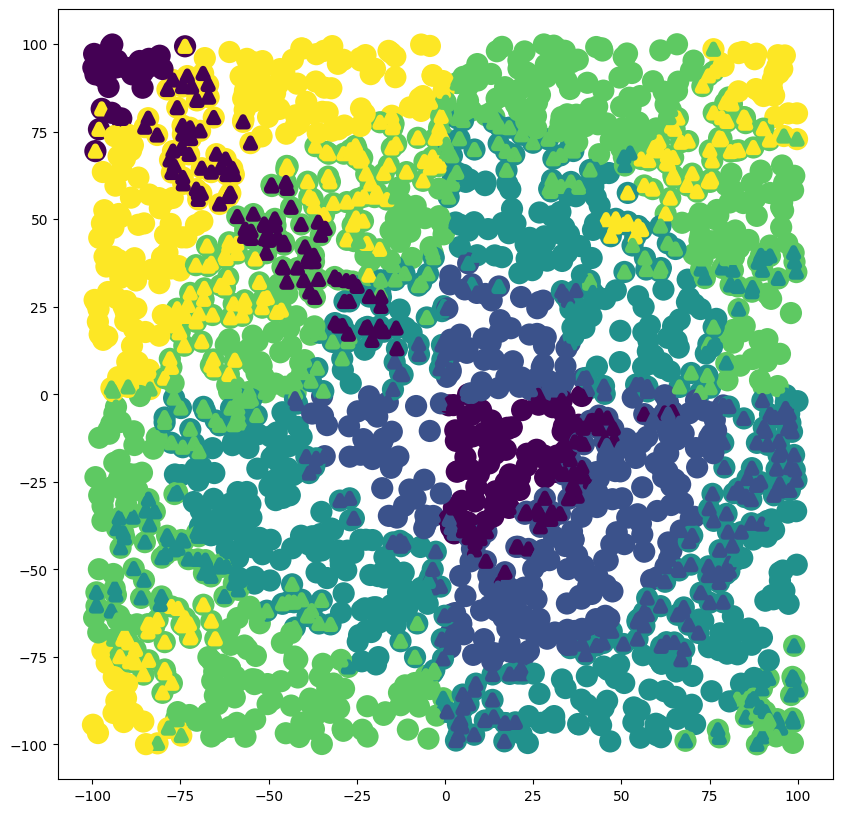

In [ ]:
df = pd.read_csv('mio1/classification/rings5-regular-training.csv')
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true = one_hot_encode(y, 5)
mlp = MLP([2,64,32,16, 5], 'relu', 'softmax', "cross-entropy")
mlp.fit(X, y_true,10000, 0.00001, 1)
y_prob = mlp.predict(X,0)
y_pred =mlp.softmax_to_one_hot(y_prob)
y_pred_col = mlp.convert_to_class_indices(y_pred)
F = mlp.f1_score(y_pred=y_pred, y_true=y_true)
print("Train F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=4)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_col, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=4)

df = pd.read_csv('mio1/classification/rings5-regular-test.csv')
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true_test = one_hot_encode(y_test, 5)

y_prob_test = mlp.predict(X_test,0)
y_pred_test = mlp.softmax_to_one_hot(y_prob_test)
y_pred_col_test = mlp.convert_to_class_indices(y_pred_test)
F = mlp.f1_score(y_pred=y_pred_test, y_true=y_true_test)
print("Test F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_col_test, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=4)

Epoch 1/10000, Train Loss: 0.21600647649322058, Error: 1.6963604111093105
Epoch 1001/10000, Train Loss: 0.4444784067652784, Error: 1.2162206066293155
Epoch 2001/10000, Train Loss: 0.4601095239569826, Error: 1.1351124471212704
Epoch 3001/10000, Train Loss: 0.5378075007977768, Error: 1.0413168118129061
Epoch 4001/10000, Train Loss: 0.5320927741965644, Error: 1.038830568054225
Epoch 5001/10000, Train Loss: 0.581502412634202, Error: 0.9167597436894513
Epoch 6001/10000, Train Loss: 0.6119544216589385, Error: 0.833534506989193
Epoch 7001/10000, Train Loss: 0.5734613250978423, Error: 0.8677052725394293
Epoch 8001/10000, Train Loss: 0.6973798929911246, Error: 0.7138497983072846
Epoch 9001/10000, Train Loss: 0.6781817864112989, Error: 0.6811600581159386


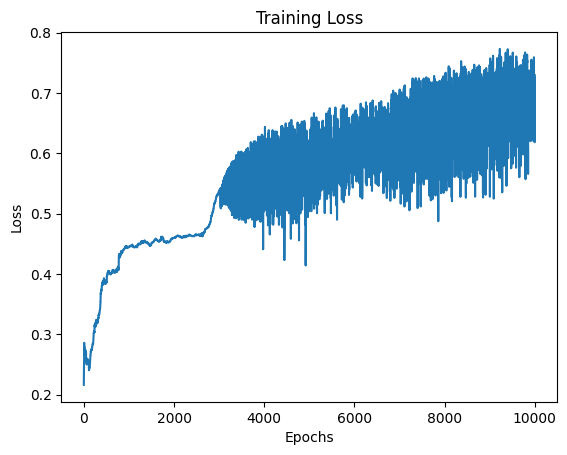

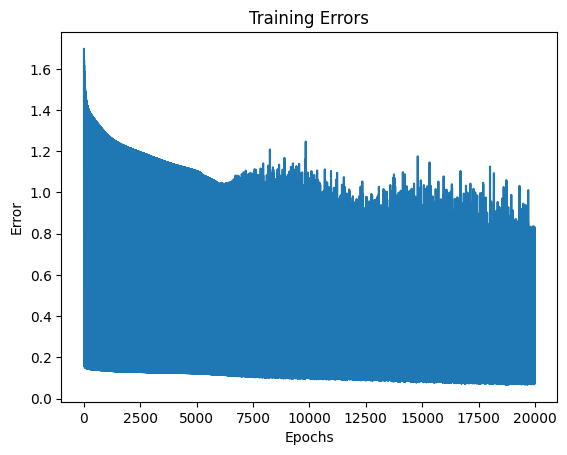

Train F-measure:  0.7447978564819395
Test F-measure:  0.5911294738747348


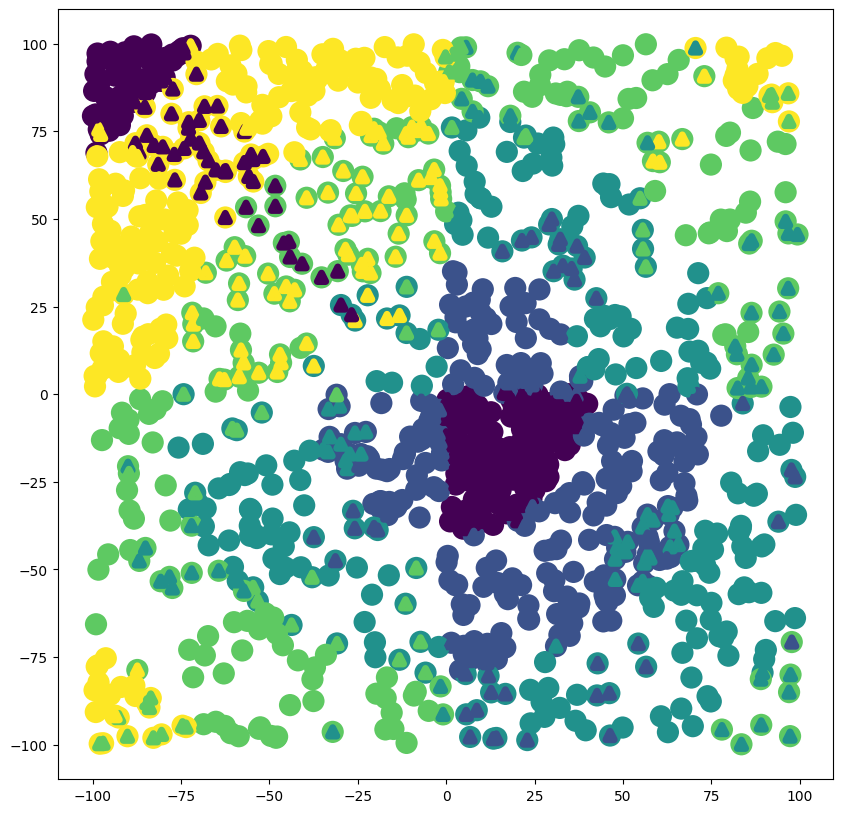

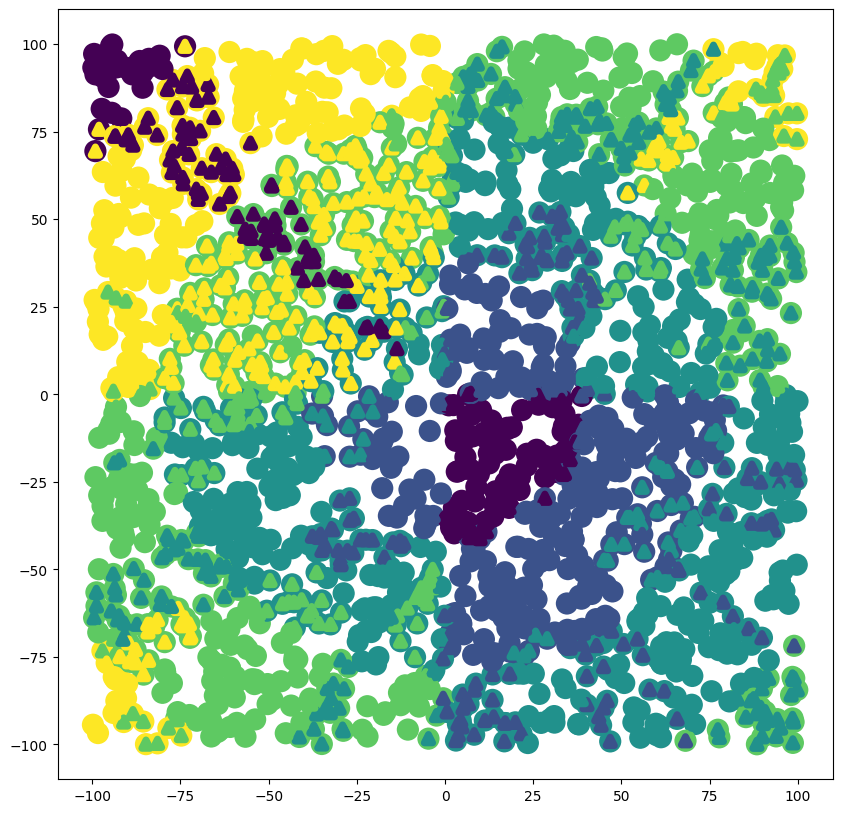

In [ ]:
df = pd.read_csv('mio1/classification/rings5-regular-training.csv')
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true = one_hot_encode(y, 5)
mlp = MLP([2,64,32,16, 5], 'tanh', 'softmax', "cross-entropy")
mlp.fit(X, y_true,10000, 0.00001, 1)
y_prob = mlp.predict(X,0)
y_pred =mlp.softmax_to_one_hot(y_prob)
y_pred_col = mlp.convert_to_class_indices(y_pred)
F = mlp.f1_score(y_pred=y_pred, y_true=y_true)
print("Train F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=4)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_col, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=4)

df = pd.read_csv('mio1/classification/rings5-regular-test.csv')
X_test = df.iloc[:, :-1].to_numpy()
y_test = df.iloc[:, -1].to_numpy().reshape(-1,1)
y_true_test = one_hot_encode(y_test, 5)

y_prob_test = mlp.predict(X_test,0)
y_pred_test = mlp.softmax_to_one_hot(y_prob_test)
y_pred_col_test = mlp.convert_to_class_indices(y_pred_test)
F = mlp.f1_score(y_pred=y_pred_test, y_true=y_true_test)
print("Test F-measure: ", F)
plt.figure(figsize=(10, 10))

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', marker='o', linewidths=10, vmin=0, vmax=4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_col_test, cmap='viridis', marker='^', linewidths= 5, vmin=0, vmax=4)


Najlepsze konfiguracje dla zbioru rings5 regular to:
- trzy warstwy ukryte + relu - test f-measure = 0.62
- trzy warstwy ukryte + tanh - test f-measure = 0.59

Czy wszyscy implementują dokładnie gradient dla funkcji ReLU?
W punkcie 0 nie istnieje pochodna, więc zależy od implementacji jaka wartość jest przypisywana dla zera lub czy pomijane są takie wartości.